TRANFORMACIÓN DE LOS DATOS


Conexión entre MySQL y Jupyter Notebook en VSCode:

En MySQL, Lo primero que debemos hacer es crear la base de datos. La base de datos para este proyecto se llamará "telecomunicaciones".Una vez creada, instalamos la librería mysql-connector-python la cual nos permitirá la conexión entre las herramientas. A continuación importar la librería mysql.connector y creamos la conexión:

In [1]:
import mysql.connector
import pandas as pd
import numpy as np
import warnings
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


#creamos la conexión al usuario propio de mysql
connection = mysql.connector.connect(
    host='Localhost',
    user='root',
    password='Punkiesunal853!',
    database='telecomunicaciones')

Importante tener en cuenta que, para utilizar la herramienta mysql.connector, se debe seguir una estructura para poder realizar las querys. Primero se debe crear un cursor para establecer la conexión y luego ejecutar la query a traves de comandos como cursor.execute().

Descripción de datos y eliminación de algunas pestañas en el dataset “Internet”.
La eliminación de pestañas se hace a partir de alguno de los siguientes criterios:

1.	Tiene demasiada información. Teniendo en cuenta que debemos realizar un análisis que nos permita reconocer el comportamiento del internet nacionalmente, pestañas que tienen, por ejemplo, información de partidos y localidades son muy específicas y podrían ser útiles para analizar casos más específicos, pero para la generalización utilizaremos las provincias solamente. 
2.	Hay tablas que son generalización de otras. Por ejemplo, Totales VMD es una generalización de Velocidad % por prov.

Teniendo en cuenta que lo anterior, para nuestro análisis conservaremos las pestañas: 
Accesos por velocidad, Velocidad % por prov,  Accesos Por Tecnología, Penetración hogares: acceso por cada 100 hogares, Penetración población: acceso por cada 100 personas, Dial-Baf, Ingresos.


Debido los archivos excel entregados tienen varias pestañas, la lectura con la herramienta que tiene MySQL se complica. Para realizarlo con esta primero debería separar todos las pestañas de interés conviertiendo, cada una de ellas, a un archivo csv,crear la tabla correspondiente y luego sí cargar el archivo con la herramienta. Por esta razón se propone una combinación de código python y MySQL para facilitar el trabajo. 

In [2]:
cursor = connection.cursor() #creamos el cursor

list_sheets_interest = ['Accesos por velocidad', 'Velocidad promedio por prov', 'Accesos Por Tecnologia', 'Penetracion hogares',
'Penetracion poblacion', 'Dial BAf', 'Ingresos'] #lista de las pestañas de interés que queremos cargar.

#Creamos las query para la creación de las tablas e inserción de data en las mismas. Cada pestaña representa una tabla en 
#MySQL

for sheet in list_sheets_interest:
    nombre_sheet = sheet.replace(" ", "_")
    
    #leemos la pestaña
    df_sheet = pd.read_excel('datasets/Internet.xlsx', sheet_name=sheet)
    
    sqltable_columns= [] 
    sqltable_columns_types = []    
    
    # Desarrollamos la query para crear las tablas, poniendo el nombre de la columna + type
    for columna in df_sheet.columns:
       nombre_columna = columna.replace(" ", "_") #unimos los nombres con _ para que puedan ser leídos por MySQL
       try:
           df_sheet['columna'] = df_sheet['columna'].astype(float)
           sqltable_columns.append(nombre_columna)         
           column_type = nombre_columna+ ' '+ 'DOUBLE'
           sqltable_columns_types.append(column_type) #Si se deja convertir en float, establecer type Double

       except:           
           sqltable_columns.append(nombre_columna) 
           column_type = nombre_columna+ ' ' +'VARCHAR(200)'
           sqltable_columns_types.append(column_type) #Si no se deja convertir en float, establecer type Varchar
    
    #unimos los nombres y types para crear la query
    sqltable_columns1 = sqltable_columns
    sqltable_columns = ', '.join(sqltable_columns)
    sqltable_columns_types = ', '.join(sqltable_columns_types) 

    cursor.execute(f"""DROP TABLE IF EXISTS {nombre_sheet}""")     

    #ejecutamos la query y creamos la tabla con sus columnas    
    cursor.execute(f"""CREATE TABLE IF NOT EXISTS {nombre_sheet} ({sqltable_columns_types})
    ENGINE=InnoDB DEFAULT CHARSET=utf8mb4 COLLATE=utf8mb4_spanish_ci""")

    #insertamos los datos en la tabla
    for i, row in df_sheet.iterrows(): #iteramos por filas
        complete_row = []
        for item in row:
            item = str(item)
            complete_row.append(item)
        placeholders = ', '.join(['%s'] * len(sqltable_columns1)) #unimos para crear la query
        complete_row = tuple(complete_row)  
        
        #ejecutamos la query para insertar la información en las tablas
        cursor.execute(f"""INSERT INTO {nombre_sheet} ({sqltable_columns}) VALUES ({placeholders})""", complete_row)
           
    connection.commit()  

Una vez cargada la información, modificamos las fechas de todas las tablas para que estén en formato DATE.

In [3]:
#tabla Accesos_por_velocidad

cursor.execute("""ALTER TABLE Accesos_por_velocidad ADD COLUMN fecha DATE""") #creamos la tabla fecha

cursor.execute("""UPDATE Accesos_por_velocidad
SET fecha = CASE 
                WHEN trimestre = 1 THEN STR_TO_DATE(CONCAT(Año, '-01-01'), '%Y-%m-%d')
                WHEN trimestre = 2 THEN STR_TO_DATE(CONCAT(Año, '-04-01'), '%Y-%m-%d')
                WHEN trimestre = 3 THEN STR_TO_DATE(CONCAT(Año, '-07-01'), '%Y-%m-%d')
                WHEN trimestre = 4 THEN STR_TO_DATE(CONCAT(Año, '-10-01'), '%Y-%m-%d')
            END;""")# convertimos año + trimestre en una fecha

cursor.execute("""ALTER TABLE Accesos_por_velocidad DROP COLUMN Año, DROP COLUMN Trimestre """)# teniendo fecha, eliminamos
#las columnas año y trimestre

In [4]:
#tabla Velocidad_promedio_por_prov

cursor.execute("""ALTER TABLE Velocidad_promedio_por_prov ADD COLUMN fecha DATE""") #creamos la tabla fecha

cursor.execute("""UPDATE Velocidad_promedio_por_prov
SET fecha = CASE 
                WHEN trimestre = 1 THEN STR_TO_DATE(CONCAT(Año, '-01-01'), '%Y-%m-%d')
                WHEN trimestre = 2 THEN STR_TO_DATE(CONCAT(Año, '-04-01'), '%Y-%m-%d')
                WHEN trimestre = 3 THEN STR_TO_DATE(CONCAT(Año, '-07-01'), '%Y-%m-%d')
                WHEN trimestre = 4 THEN STR_TO_DATE(CONCAT(Año, '-10-01'), '%Y-%m-%d')
            END;""")# convertimos año + trimestre en una fecha

cursor.execute("""ALTER TABLE Velocidad_promedio_por_prov DROP COLUMN Año, DROP COLUMN Trimestre """)#teniendo fecha,
#eliminamos las columnas año y trimestre

In [5]:
#tabla Accesos_Por_Tecnologia

# en esta tabla encontramos que sus datos tienen errores, así que los corregimos.

#trimestres con * al final
cursor.execute("""UPDATE Accesos_Por_Tecnologia SET trimestre = REPLACE(trimestre, ' *', '') WHERE trimestre LIKE '% *' """)

#años con * al final
cursor.execute("""UPDATE Accesos_Por_Tecnologia SET año = REPLACE(año, ' *', '') WHERE año LIKE '% *' """)

#borramos datos que no tengan trimestre
cursor.execute("""DELETE FROM Accesos_Por_Tecnologia WHERE trimestre = 'nan' """)

#borramos datos que no tengan año
cursor.execute("""DELETE FROM Accesos_Por_Tecnologia WHERE año = '*' """)

cursor.execute("""ALTER TABLE Accesos_Por_Tecnologia ADD COLUMN fecha DATE""") #creamos la tabla fecha

cursor.execute("""UPDATE Accesos_Por_Tecnologia
SET fecha = CASE 
                WHEN trimestre = 1 THEN STR_TO_DATE(CONCAT(Año, '-01-01'), '%Y-%m-%d')
                WHEN trimestre = 2 THEN STR_TO_DATE(CONCAT(Año, '-04-01'), '%Y-%m-%d')
                WHEN trimestre = 3 THEN STR_TO_DATE(CONCAT(Año, '-07-01'), '%Y-%m-%d')
                WHEN trimestre = 4 THEN STR_TO_DATE(CONCAT(Año, '-10-01'), '%Y-%m-%d')
            END;""")# convertimos año + trimestre en una fecha

cursor.execute("""ALTER TABLE Accesos_Por_Tecnologia DROP COLUMN Año, DROP COLUMN Trimestre """) #teniendo fecha,
#eliminamos las columnas año y trimestre

In [6]:
#tabla Penetracion hogares

cursor.execute("""ALTER TABLE Penetracion_hogares ADD COLUMN fecha DATE""") #creamos la tabla fecha

cursor.execute("""UPDATE Penetracion_hogares
SET fecha = CASE 
                WHEN trimestre = 1 THEN STR_TO_DATE(CONCAT(Año, '-01-01'), '%Y-%m-%d')
                WHEN trimestre = 2 THEN STR_TO_DATE(CONCAT(Año, '-04-01'), '%Y-%m-%d')
                WHEN trimestre = 3 THEN STR_TO_DATE(CONCAT(Año, '-07-01'), '%Y-%m-%d')
                WHEN trimestre = 4 THEN STR_TO_DATE(CONCAT(Año, '-10-01'), '%Y-%m-%d')
            END;""")# convertimos año + trimestre en una fecha

cursor.execute("""ALTER TABLE Penetracion_hogares DROP COLUMN Año, DROP COLUMN Trimestre """) #teniendo fecha,
#eliminamos las columnas año y trimestre

In [7]:
#tabla Penetracion_poblacion

cursor.execute("""ALTER TABLE Penetracion_poblacion ADD COLUMN fecha DATE""") #creamos la tabla fecha

cursor.execute("""UPDATE Penetracion_poblacion
SET fecha = CASE 
                WHEN trimestre = 1 THEN STR_TO_DATE(CONCAT(Año, '-01-01'), '%Y-%m-%d')
                WHEN trimestre = 2 THEN STR_TO_DATE(CONCAT(Año, '-04-01'), '%Y-%m-%d')
                WHEN trimestre = 3 THEN STR_TO_DATE(CONCAT(Año, '-07-01'), '%Y-%m-%d')
                WHEN trimestre = 4 THEN STR_TO_DATE(CONCAT(Año, '-10-01'), '%Y-%m-%d')
            END;""")# convertimos año + trimestre en una fecha

cursor.execute("""ALTER TABLE Penetracion_poblacion DROP COLUMN Año, DROP COLUMN Trimestre """) #teniendo fecha,
#eliminamos las columnas año y trimestre

In [8]:
#tabla Dial_BAf

cursor.execute("""ALTER TABLE Dial_BAf ADD COLUMN fecha DATE""") #creamos la tabla fecha

cursor.execute("""UPDATE Dial_BAf
SET fecha = CASE 
                WHEN trimestre = 1 THEN STR_TO_DATE(CONCAT(Año, '-01-01'), '%Y-%m-%d')
                WHEN trimestre = 2 THEN STR_TO_DATE(CONCAT(Año, '-04-01'), '%Y-%m-%d')
                WHEN trimestre = 3 THEN STR_TO_DATE(CONCAT(Año, '-07-01'), '%Y-%m-%d')
                WHEN trimestre = 4 THEN STR_TO_DATE(CONCAT(Año, '-10-01'), '%Y-%m-%d')
            END;""")# convertimos año + trimestre en una fecha

cursor.execute("""ALTER TABLE Dial_BAf DROP COLUMN Año, DROP COLUMN Trimestre """) #teniendo fecha,
#eliminamos las columnas año y trimestre

In [9]:
#tabla Ingresos

cursor.execute("""ALTER TABLE Ingresos ADD COLUMN fecha DATE""") #creamos la tabla fecha

cursor.execute("""UPDATE Ingresos
SET fecha = CASE 
                WHEN trimestre = 1 THEN STR_TO_DATE(CONCAT(Año, '-01-01'), '%Y-%m-%d')
                WHEN trimestre = 2 THEN STR_TO_DATE(CONCAT(Año, '-04-01'), '%Y-%m-%d')
                WHEN trimestre = 3 THEN STR_TO_DATE(CONCAT(Año, '-07-01'), '%Y-%m-%d')
                WHEN trimestre = 4 THEN STR_TO_DATE(CONCAT(Año, '-10-01'), '%Y-%m-%d')
            END;""")# convertimos año + trimestre en una fecha

cursor.execute("""ALTER TABLE Ingresos DROP COLUMN Año, DROP COLUMN Trimestre """) #teniendo fecha,
#eliminamos las columnas año y trimestre

connection.commit()  

Buscamos nulos y valores nan en las tablas. 

In [10]:
#Accesos_por_velocidad 

#Por cada columna, hacemos una suma de los nulos
Nulos = cursor.execute (""" 
    SELECT 
        SUM(CASE WHEN fecha IS NULL THEN 1 ELSE 0 END) AS nulos_columna1,
        SUM(CASE WHEN Provincia IS NULL THEN 1 ELSE 0 END) AS nulos_columna2,
        SUM(CASE WHEN HASTA_512_kbps IS NULL THEN 1 ELSE 0 END) AS nulos_columna3,
        SUM(CASE WHEN De_512_Kbps__a_1_Mbps IS NULL THEN 1 ELSE 0 END) AS nulos_columna4,
        SUM(CASE WHEN Den_1_Mbps_a6_Mbps IS NULL THEN 1 ELSE 0 END) AS nulos_columna5,
        SUM(CASE WHEN De_6_Mbps_a_10_Mbps IS NULL THEN 1 ELSE 0 END) AS nulos_columna6,
        SUM(CASE WHEN De_10_Mbps_a_20_Mbps IS NULL THEN 1 ELSE 0 END) AS nulos_columna7,
        SUM(CASE WHEN De_20_Mbps_a_30_Mbps IS NULL THEN 1 ELSE 0 END) AS nulos_columna8,
        SUM(CASE WHEN `30_Mbps_o_más` IS NULL THEN 1 ELSE 0 END) AS nulos_columna9,
        SUM(CASE WHEN OTROS IS NULL THEN 1 ELSE 0 END) AS nulos_columna10,
        SUM(CASE WHEN Total IS NULL THEN 1 ELSE 0 END) AS nulos_columna11
    FROM Accesos_por_velocidad 
""")

#recolectamos los datos de la query anterior
filas = cursor.fetchall()

#transformamos la query en un pandas dataaframe para poder revisar cuántos nulos hay. 
df_nulos = pd.DataFrame(filas, columns=['column1','column2','column3','column4','column5','column6','column7','column8',
  'column9','column10','column11'])
print(df_nulos)

#No existen nulos en Accesos_por_velocidad

  column1 column2 column3 column4 column5 column6 column7 column8 column9  \
0       0       0       0       0       0       0       0       0       0   

  column10 column11  
0        0        0  


In [11]:
#La columna 'OTROS' en Accesos_por_velocidad tiene valores nan. Vamos a cambiar estos valores por 0, asumiendo que estas
# provincias no tienen otros accesso_por velocidad. 

cursor.execute (""" UPDATE Accesos_por_velocidad SET OTROS = 0 WHERE OTROS = 'nan' """)   

connection.commit() 

In [12]:
#Velocidad_promedio_por_prov 

Nulos = cursor.execute (""" 
    SELECT 
        SUM(CASE WHEN fecha IS NULL THEN 1 ELSE 0 END) AS nulos_columna1,
        SUM(CASE WHEN Provincia IS NULL THEN 1 ELSE 0 END) AS nulos_columna2,
        SUM(CASE WHEN Mbps_Media_de_bajada IS NULL THEN 1 ELSE 0 END) AS nulos_columna3        
    FROM Velocidad_promedio_por_prov  
""")

filas = cursor.fetchall()
df_nulos = pd.DataFrame(filas, columns=['column1','column2','column3'])
print(df_nulos)

#No existen nulos en Velocidad_promedio_por_prov 

  column1 column2 column3
0       0       0       0


In [13]:
#Accesos_Por_Tecnologia 

Nulos = cursor.execute (""" SELECT 
    SUM(CASE WHEN fecha IS NULL THEN 1 ELSE 0 END) AS nulos_columna1,
    SUM(CASE WHEN Provincia IS NULL THEN 1 ELSE 0 END) AS nulos_columna2,
    SUM(CASE WHEN ADSL IS NULL THEN 1 ELSE 0 END) AS nulos_columna3,
    SUM(CASE WHEN Cablemodem IS NULL THEN 1 ELSE 0 END) AS nulos_columna4,
    SUM(CASE WHEN 'Fibra óptica' IS NULL THEN 1 ELSE 0 END) AS nulos_columna5,
    SUM(CASE WHEN Wireless IS NULL THEN 1 ELSE 0 END) AS nulos_columna6,
    SUM(CASE WHEN Otros IS NULL THEN 1 ELSE 0 END) AS nulos_columna7,
    SUM(CASE WHEN Total IS NULL THEN 1 ELSE 0 END) AS nulos_columna8
FROM Accesos_Por_Tecnologia """)


filas = cursor.fetchall()
df_nulos = pd.DataFrame(filas, columns=['column1','column2','column3','column4','column5','column6','column7','column8'])
print(df_nulos)

#No existen nulos en Accesos_Por_Tecnologia 

  column1 column2 column3 column4 column5 column6 column7 column8
0       0       0       0       0       0       0       0       0

In [14]:
#Penetracion_hogares 

Nulos = cursor.execute (""" SELECT 
    SUM(CASE WHEN fecha IS NULL THEN 1 ELSE 0 END) AS nulos_columna1,
    SUM(CASE WHEN Provincia IS NULL THEN 1 ELSE 0 END) AS nulos_columna2,
    SUM(CASE WHEN Accesos_por_cada_100_hogares IS NULL THEN 1 ELSE 0 END) AS nulos_columna3    
FROM Penetracion_hogares """)


filas = cursor.fetchall()
df_nulos = pd.DataFrame(filas, columns=['column1','column2','column3'])
print(df_nulos)

#No existen nulos en Penetracion_hogares

  column1 column2 column3
0       0       0       0


In [15]:
#Penetracion_poblacion

Nulos = cursor.execute (""" SELECT 
    SUM(CASE WHEN fecha IS NULL THEN 1 ELSE 0 END) AS nulos_columna1,
    SUM(CASE WHEN Provincia IS NULL THEN 1 ELSE 0 END) AS nulos_columna2,
    SUM(CASE WHEN Accesos_por_cada_100_hab IS NULL THEN 1 ELSE 0 END) AS nulos_columna3    
FROM Penetracion_poblacion """)


filas = cursor.fetchall()
df_nulos = pd.DataFrame(filas, columns=['column1','column2','column3'])
print(df_nulos)

#No existen nulos en Penetracion_poblacion

  column1 column2 column3
0       0       0       0


In [16]:
#Dial_BAf

Nulos = cursor.execute (""" SELECT 
    SUM(CASE WHEN fecha IS NULL THEN 1 ELSE 0 END) AS nulos_columna1,
    SUM(CASE WHEN Provincia IS NULL THEN 1 ELSE 0 END) AS nulos_columna2,
    SUM(CASE WHEN Banda_ancha_fija IS NULL THEN 1 ELSE 0 END) AS nulos_columna3,
    SUM(CASE WHEN Dial_up IS NULL THEN 1 ELSE 0 END) AS nulos_columna4                       
FROM Dial_BAf """)


filas = cursor.fetchall()
df_nulos = pd.DataFrame(filas, columns=['column1','column2','column3','column4'])
print(df_nulos)

# No existen nulos en Dial_BAf

  column1 column2 column3 column4
0       0       0       0       0


In [17]:
#La columna 'Dial_up' en Dial_BAf tiene valores nan. Vamos a cambiar estos valores por 0, asumiendo que estas
# provincias no tienen este tipo de tecnología como acceso a internet

cursor.execute (""" UPDATE Dial_BAf SET Dial_up = 0 WHERE Dial_up = 'nan' """)   

connection.commit() 

In [18]:
#Ingresos

Nulos = cursor.execute (""" SELECT 
    SUM(CASE WHEN fecha IS NULL THEN 1 ELSE 0 END) AS nulos_columna1,
    SUM(CASE WHEN Ingresos_miles_de_pesos IS NULL THEN 1 ELSE 0 END) AS nulos_columna2,
    SUM(CASE WHEN Periodo IS NULL THEN 1 ELSE 0 END) AS nulos_columna3                          
FROM Ingresos """)


filas = cursor.fetchall()
df_nulos = pd.DataFrame(filas, columns=['column1','column2','column3'])
print(df_nulos)

# No existen nulos en Ingresos

connection.commit()  

  column1 column2 column3
0       0       0       0


Corregimos los types de las columnas.

In [19]:
# Verificar que las columnas necesarias de Accesos_por_velocidad se puedan convertir a FLOAT

cursor.execute ("""
    SELECT 
        `HASTA_512_kbps`, CAST(`HASTA_512_kbps` AS FLOAT) AS `float1`,
        `De_512_Kbps__a_1_Mbps`, CAST(`De_512_Kbps__a_1_Mbps` AS FLOAT) AS `float2`,
        `Den_1_Mbps_a6_Mbps`, CAST(`Den_1_Mbps_a6_Mbps` AS FLOAT) AS `float3`,
        `De_6_Mbps_a_10_Mbps`, CAST(`De_6_Mbps_a_10_Mbps` AS FLOAT) AS `float4`,
        `De_10_Mbps_a_20_Mbps`, CAST(`De_10_Mbps_a_20_Mbps` AS FLOAT) AS `float5`,
        `De_20_Mbps_a_30_Mbps`, CAST(`De_20_Mbps_a_30_Mbps` AS FLOAT) AS `float6`,
        `30_Mbps_o_más`, CAST(`30_Mbps_o_más` AS FLOAT) AS `float7`,
        `OTROS`, CAST(`OTROS` AS FLOAT) AS `float8`,   
        `Total`, CAST(`Total` AS FLOAT) AS `float9`      
    FROM 
        `Accesos_por_velocidad`
""")

resultados_float = cursor.fetchall()

In [20]:
#modificamos los types de estas columnas

cursor.execute (""" ALTER TABLE `Accesos_por_velocidad`
    MODIFY COLUMN `HASTA_512_kbps` FLOAT,
    MODIFY COLUMN `De_512_Kbps__a_1_Mbps` FLOAT,
    MODIFY COLUMN `Den_1_Mbps_a6_Mbps` FLOAT,
    MODIFY COLUMN `De_6_Mbps_a_10_Mbps` FLOAT,
    MODIFY COLUMN `De_10_Mbps_a_20_Mbps` FLOAT,
    MODIFY COLUMN `De_20_Mbps_a_30_Mbps` FLOAT,
    MODIFY COLUMN `30_Mbps_o_más` FLOAT,
    MODIFY COLUMN `OTROS` FLOAT,
    MODIFY COLUMN `Total` FLOAT""")

In [21]:
# Verificar que las columnas necesarias de Velocidad_promedio_por_prov se puedan convertir a FLOAT 

cursor.execute ("""
    SELECT 
        `Mbps_Media_de_bajada`, CAST(`Mbps_Media_de_bajada` AS FLOAT) AS `float1`            
    FROM 
        `Velocidad_promedio_por_prov`
""")

resultados_float = cursor.fetchall()

In [22]:
#modificamos los types de estas columnas

cursor.execute (""" ALTER TABLE `Velocidad_promedio_por_prov`
    MODIFY COLUMN `Mbps_Media_de_bajada` FLOAT """)

In [23]:
# Verificar que las columnas necesarias de Accesos_Por_Tecnologia se puedan convertir a FLOAT

cursor.execute ("""
    SELECT 
        `ADSL`, CAST(`ADSL` AS FLOAT) AS `float1`,
        `Cablemodem`, CAST(`Cablemodem` AS FLOAT) AS `float2`,
        `Fibra_óptica`, CAST(`Fibra_óptica` AS FLOAT) AS `float3`,
        `Wireless`, CAST(`Wireless` AS FLOAT) AS `float4`,
        `Otros`, CAST(`Otros` AS FLOAT) AS `float5`,
        `Total`, CAST(`Total` AS FLOAT) AS `float6`              
    FROM 
        `Accesos_Por_Tecnologia`
""")

resultados_float = cursor.fetchall()

In [24]:
#modificamos los types de estas columnas

cursor.execute (""" ALTER TABLE `Accesos_Por_Tecnologia`
    MODIFY COLUMN `ADSL` FLOAT,
    MODIFY COLUMN `Cablemodem` FLOAT,
    MODIFY COLUMN `Fibra_óptica` FLOAT,
    MODIFY COLUMN `Wireless` FLOAT,
    MODIFY COLUMN `Otros` FLOAT,
    MODIFY COLUMN `Total` FLOAT""")

In [25]:
# Verificar que las columnas necesarias de Penetracion_hogares se puedan convertir a FLOAT

cursor.execute ("""
    SELECT 
        `Accesos_por_cada_100_hogares`, CAST(`Accesos_por_cada_100_hogares` AS FLOAT) AS `float1`                      
    FROM 
        `Penetracion_hogares`
""")

resultados_float = cursor.fetchall()

In [26]:
#modificamos los types de estas columnas

cursor.execute (""" ALTER TABLE `Penetracion_hogares`
    MODIFY COLUMN `Accesos_por_cada_100_hogares` FLOAT """)

In [27]:
# Verificar que las columnas necesarias de Penetracion_poblacion se puedan convertir a FLOAT

cursor.execute ("""
    SELECT 
        `Accesos_por_cada_100_hab`, CAST(`Accesos_por_cada_100_hab` AS FLOAT) AS `float1`                      
    FROM 
        `Penetracion_poblacion`
""")

resultados_float = cursor.fetchall()

In [28]:
#modificamos los types de estas columnas

cursor.execute (""" ALTER TABLE `Penetracion_poblacion`
    MODIFY COLUMN `Accesos_por_cada_100_hab` FLOAT """)

In [29]:
# Verificar que las columnas necesarias de Dial_BAf se puedan convertir a FLOAT

cursor.execute ("""
    SELECT 
        `Banda_ancha_fija`, CAST(`Banda_ancha_fija` AS FLOAT) AS `float1`,
        `Dial_up`, CAST(`Dial_up` AS FLOAT) AS `float2`,
        `Total`, CAST(`Total` AS FLOAT) AS `float3`                      
    FROM 
        `Dial_BAf`
""")

resultados_float = cursor.fetchall()

In [30]:
#modificamos los types de estas columnas

cursor.execute (""" ALTER TABLE `Dial_BAf`
    MODIFY COLUMN `Banda_ancha_fija` FLOAT,
    MODIFY COLUMN `Dial_up` FLOAT,
    MODIFY COLUMN `Total` FLOAT """)

In [31]:
# Verificar que las columnas necesarias de Ingresos se puedan convertir a FLOAT

cursor.execute ("""
    SELECT 
        `Ingresos_miles_de_pesos`, CAST(`Ingresos_miles_de_pesos` AS FLOAT) AS `float1`                             
    FROM 
        `Ingresos`
""")

resultados_float = cursor.fetchall()

In [32]:
#modificamos los types de estas columnas

cursor.execute (""" ALTER TABLE `Ingresos`
    MODIFY COLUMN `Ingresos_miles_de_pesos` FLOAT """)

connection.commit()  

Ahora que tenemos todo en en el formato correcto, vamos a revisar si hay outliers. La mayoría de tablas están por provincias, por lo que se analizarán los datos por provincia y si algún dato se encuentra por fuera del rango [promedio - 3 * desviación estandar, promedio + 3 * desviación estandar] por provincia, se le asignará el promedio de la provincia. Se utilizará una combinación de código MySQL y python para lograr un poco de simplificación. 
Para el caso de la tabla Ingresos, que no está discriminada por provincias, no se realiza este proceso.

In [33]:
#Con la tabla Accesos_por_velocidad

#determinamos las columnas de la tabla, tomamos los resultados de la query y ponemos los nombres de las columnas en una lista
cursor.execute("""SHOW COLUMNS FROM Accesos_por_velocidad""")
columnas = cursor.fetchall()
nombres_tipos_columnas = [(columna[0],columna[1]) for columna in columnas]

#determinamos las diferentes provincias, tomamos los resultados de la query y ponemos los nombres de las columnas en una lista
cursor.execute("""SELECT DISTINCT Provincia FROM Accesos_por_velocidad""")
Provincias = cursor.fetchall()
nombres_Provincias = [provincia[0] for provincia in Provincias]

#realizamos un for anidado donde por cada columna, vamos a ir viendo, por provincia cuál es el promedio y desviación estandar
# y, si el dato se sale de [promedio - 3 * desviación estandar, promedio + 3 * desviación estandar], actualizar.
for column in nombres_tipos_columnas:
    if column[1] == 'float':
        for provincia in nombres_Provincias:
            # Calcula el promedio 
            cursor.execute(f"""SELECT AVG(`{column[0]}`) INTO @average FROM Accesos_por_velocidad WHERE `{column[0]}` <> 0
                AND Provincia = %s""", (provincia,))
            
            # Calcula la desviación estándar
            cursor.execute(f""" SELECT STDDEV(`{column[0]}`) INTO @Desviacion FROM Accesos_por_velocidad WHERE Provincia = %s
            """, (provincia,))
            
            # Actualiza los valores en la tabla
            cursor.execute(f"""UPDATE Accesos_por_velocidad SET `{column[0]}` = @average
                WHERE Provincia = %s AND (`{column[0]}` > (@average + (3*@Desviacion)) OR
                `{column[0]}` < (@average - (3*@Desviacion))) """, (provincia,))
            
            connection.commit() 

In [34]:
#Con la tabla Velocidad_promedio_por_prov 

#determinamos las columnas de la tabla, tomamos los resultados de la query y ponemos los nombres de las columnas en una lista
cursor.execute("""SHOW COLUMNS FROM Velocidad_promedio_por_prov""")
columnas = cursor.fetchall()
nombres_tipos_columnas = [(columna[0],columna[1]) for columna in columnas]

#determinamos las diferentes provincias, tomamos los resultados de la query y ponemos los nombres de las columnas en una lista
cursor.execute("""SELECT DISTINCT Provincia FROM Velocidad_promedio_por_prov""")
Provincias = cursor.fetchall()
nombres_Provincias = [provincia[0] for provincia in Provincias]

#realizamos un for anidado donde por cada columna, vamos a ir viendo, por provincia cuál es el promedio y desviación estandar
# y, si el dato se sale de [promedio - 3 * desviación estandar, promedio + 3 * desviación estandar], actualizar.
for column in nombres_tipos_columnas:
    if column[1] == 'float':
        for provincia in nombres_Provincias:
            # Calcula el promedio
            cursor.execute(f"""SELECT AVG(`{column[0]}`) INTO @average FROM Velocidad_promedio_por_prov WHERE `{column[0]}` <> 0
                AND Provincia = %s""", (provincia,))
            
            # Calcula la desviación estándar
            cursor.execute(f""" SELECT STDDEV(`{column[0]}`) INTO @Desviacion FROM Velocidad_promedio_por_prov WHERE Provincia = %s
            """, (provincia,))
            
            # Actualiza los valores en la tabla
            cursor.execute(f"""UPDATE Velocidad_promedio_por_prov SET `{column[0]}` = @average
                WHERE Provincia = %s AND (`{column[0]}` > (@average + (3*@Desviacion)) OR
                `{column[0]}` < (@average - (3*@Desviacion))) """, (provincia,))
            
            connection.commit() 

In [35]:
    
#Con la tabla Accesos_Por_Tecnologia

#determinamos las columnas de la tabla, tomamos los resultados de la query y ponemos los nombres de las columnas en una lista
cursor.execute("""SHOW COLUMNS FROM Accesos_Por_Tecnologia""")
columnas = cursor.fetchall()
nombres_tipos_columnas = [(columna[0],columna[1]) for columna in columnas]

#determinamos las diferentes provincias, tomamos los resultados de la query y ponemos los nombres de las columnas en una lista
cursor.execute("""SELECT DISTINCT Provincia FROM Accesos_Por_Tecnologia""")
Provincias = cursor.fetchall()
nombres_Provincias = [provincia[0] for provincia in Provincias]

#realizamos un for anidado donde por cada columna, vamos a ir viendo, por provincia cuál es el promedio y desviación estandar
# y, si el dato se sale de [promedio - 3 * desviación estandar, promedio + 3 * desviación estandar], actualizar.
for column in nombres_tipos_columnas:
    if column[1] == 'float':
        for provincia in nombres_Provincias:
            # Calcula el promedio
            cursor.execute(f"""SELECT AVG(`{column[0]}`) INTO @average FROM Accesos_Por_Tecnologia WHERE `{column[0]}` <> 0
                AND Provincia = %s""", (provincia,))
            
            # Calcula la desviación estándar
            cursor.execute(f""" SELECT STDDEV(`{column[0]}`) INTO @Desviacion FROM Accesos_Por_Tecnologia WHERE Provincia = %s
            """, (provincia,))
            
            # Actualiza los valores en la tabla
            cursor.execute(f"""UPDATE Accesos_Por_Tecnologia SET `{column[0]}` = @average
                WHERE Provincia = %s AND (`{column[0]}` > (@average + (3*@Desviacion)) OR
                `{column[0]}` < (@average - (3*@Desviacion))) """, (provincia,))
            
            connection.commit()

In [36]:
#Con la tabla Penetracion_hogares

#determinamos las columnas de la tabla, tomamos los resultados de la query y ponemos los nombres de las columnas en una lista
cursor.execute("""SHOW COLUMNS FROM Penetracion_hogares""")
columnas = cursor.fetchall()
nombres_tipos_columnas = [(columna[0],columna[1]) for columna in columnas]

#determinamos las diferentes provincias, tomamos los resultados de la query y ponemos los nombres de las columnas en una lista
cursor.execute("""SELECT DISTINCT Provincia FROM Penetracion_hogares""")
Provincias = cursor.fetchall()
nombres_Provincias = [provincia[0] for provincia in Provincias]

#realizamos un for anidado donde por cada columna, vamos a ir viendo, por provincia cuál es el promedio y desviación estandar
# y, si el dato se sale de [promedio - 3 * desviación estandar, promedio + 3 * desviación estandar], actualizar.
for column in nombres_tipos_columnas:
    if column[1] == 'float':
        for provincia in nombres_Provincias:
            # Calcula el promedio
            cursor.execute(f"""SELECT AVG(`{column[0]}`) INTO @average FROM Penetracion_hogares WHERE `{column[0]}` <> 0
                AND Provincia = %s""", (provincia,))
            
            # Calcula la desviación estándar
            cursor.execute(f""" SELECT STDDEV(`{column[0]}`) INTO @Desviacion FROM Penetracion_hogares WHERE Provincia = %s
            """, (provincia,))
            
            # Actualiza los valores en la tabla
            cursor.execute(f"""UPDATE Penetracion_hogares SET `{column[0]}` = @average
                WHERE Provincia = %s AND (`{column[0]}` > (@average + (3*@Desviacion)) OR
                `{column[0]}` < (@average - (3*@Desviacion))) """, (provincia,))
            
            connection.commit()

In [37]:
#Con la tabla Penetracion_poblacion

#determinamos las columnas de la tabla, tomamos los resultados de la query y ponemos los nombres de las columnas en una lista
cursor.execute("""SHOW COLUMNS FROM Penetracion_poblacion""")
columnas = cursor.fetchall()
nombres_tipos_columnas = [(columna[0],columna[1]) for columna in columnas]

#determinamos las diferentes provincias, tomamos los resultados de la query y ponemos los nombres de las columnas en una lista
cursor.execute("""SELECT DISTINCT Provincia FROM Penetracion_poblacion""")
Provincias = cursor.fetchall()
nombres_Provincias = [provincia[0] for provincia in Provincias]

#realizamos un for anidado donde por cada columna, vamos a ir viendo, por provincia cuál es el promedio y desviación estandar
# y, si el dato se sale de [promedio - 3 * desviación estandar, promedio + 3 * desviación estandar], actualizar.
for column in nombres_tipos_columnas:
    if column[1] == 'float':
        for provincia in nombres_Provincias:
            # Calcula el promedio
            cursor.execute(f"""SELECT AVG(`{column[0]}`) INTO @average FROM Penetracion_poblacion WHERE `{column[0]}` <> 0
                AND Provincia = %s""", (provincia,))
            
            # Calcula la desviación estándar
            cursor.execute(f""" SELECT STDDEV(`{column[0]}`) INTO @Desviacion FROM Penetracion_poblacion WHERE Provincia = %s
            """, (provincia,))
            
            # Actualiza los valores en la tabla
            cursor.execute(f"""UPDATE Penetracion_poblacion SET `{column[0]}` = @average
                WHERE Provincia = %s AND (`{column[0]}` > (@average + (3*@Desviacion)) OR
                `{column[0]}` < (@average - (3*@Desviacion))) """, (provincia,))
            
            connection.commit()

In [38]:
#Con la tabla Dial_BAf

#determinamos las columnas de la tabla, tomamos los resultados de la query y ponemos los nombres de las columnas en una lista
cursor.execute("""SHOW COLUMNS FROM Dial_BAf""")
columnas = cursor.fetchall()
nombres_tipos_columnas = [(columna[0],columna[1]) for columna in columnas]

#determinamos las diferentes provincias, tomamos los resultados de la query y ponemos los nombres de las columnas en una lista
cursor.execute("""SELECT DISTINCT Provincia FROM Dial_BAf""")
Provincias = cursor.fetchall()
nombres_Provincias = [provincia[0] for provincia in Provincias]

#realizamos un for anidado donde por cada columna, vamos a ir viendo, por provincia cuál es el promedio y desviación estandar
# y, si el dato se sale de [promedio - 3 * desviación estandar, promedio + 3 * desviación estandar], actualizar.
for column in nombres_tipos_columnas:
    if column[1] == 'float':
        for provincia in nombres_Provincias:
            # Calcula el promedio
            cursor.execute(f"""SELECT AVG(`{column[0]}`) INTO @average FROM Dial_BAf WHERE `{column[0]}` <> 0
                AND Provincia = %s""", (provincia,))
            
            # Calcula la desviación estándar
            cursor.execute(f""" SELECT STDDEV(`{column[0]}`) INTO @Desviacion FROM Dial_BAf WHERE Provincia = %s
            """, (provincia,))
            
            # Actualiza los valores en la tabla
            cursor.execute(f"""UPDATE Dial_BAf SET `{column[0]}` = @average
                WHERE Provincia = %s AND (`{column[0]}` > (@average + (3*@Desviacion)) OR
                `{column[0]}` < (@average - (3*@Desviacion))) """, (provincia,))
            
            connection.commit()

Por último, en cuanto a transformaciones, realizamos la inspección de duplicados.

In [39]:
#Con la tabla Accesos_por_velocidad

#determinamos las columnas de la tabla, tomamos los resultados de la query y ponemos los nombres de las columnas en una lista
cursor.execute("""SHOW COLUMNS FROM Accesos_por_velocidad""")
columnas = cursor.fetchall()
nombres_tipos_columnas = [(columna[0]) for columna in columnas]
cadena_tipos_columnas =  ', '.join(nombres_tipos_columnas) #unimos para poder realizar la query

#realizamos una query donde agrupamos por todas las columnas y vemos si el conteo tiene alguno mayor a uno
df_duplicates = pd.read_sql(f""" SELECT {cadena_tipos_columnas}, COUNT(*)
FROM Accesos_por_velocidad
GROUP BY {cadena_tipos_columnas}
HAVING COUNT(*) > 1 """, con=connection)

#df_duplicates

#df_duplicates es un dataframe vacío, por lo que no existen duplicados en la tabla Accesos_por_velocidad

In [40]:
#Con la tabla Velocidad_promedio_por_prov

#determinamos las columnas de la tabla, tomamos los resultados de la query y ponemos los nombres de las columnas en una list
cursor.execute("""SHOW COLUMNS FROM Velocidad_promedio_por_prov""")
columnas = cursor.fetchall()
nombres_tipos_columnas = [(columna[0]) for columna in columnas]
cadena_tipos_columnas =  ', '.join(nombres_tipos_columnas)

#realizamos una query donde agrupamos por todas las columnas y vemos si el conteo tiene alguno mayor a uno
df_duplicates = pd.read_sql(f""" SELECT {cadena_tipos_columnas}, COUNT(*)
FROM Velocidad_promedio_por_prov
GROUP BY {cadena_tipos_columnas}
HAVING COUNT(*) > 1 """, con=connection)

#df_duplicates

#df_duplicates es un dataframe vacío, por lo que no existen duplicados en la tabla Velocidad_promedio_por_prov

In [41]:
#Con la tabla Accesos_Por_Tecnologia

#determinamos las columnas de la tabla, tomamos los resultados de la query y ponemos los nombres de las columnas en una list
cursor.execute("""SHOW COLUMNS FROM Accesos_Por_Tecnologia""")
columnas = cursor.fetchall()
nombres_tipos_columnas = [(columna[0]) for columna in columnas]
cadena_tipos_columnas =  ', '.join(nombres_tipos_columnas)

#realizamos una query donde agrupamos por todas las columnas y vemos si el conteo tiene alguno mayor a uno
df_duplicates = pd.read_sql(f""" SELECT {cadena_tipos_columnas}, COUNT(*)
FROM Accesos_Por_Tecnologia
GROUP BY {cadena_tipos_columnas}
HAVING COUNT(*) > 1 """, con=connection)

#df_duplicates

#df_duplicates es un dataframe vacío, por lo que no existen duplicados en la tabla Accesos_Por_Tecnologia

In [42]:
#Con la tabla Penetracion_hogares

#determinamos las columnas de la tabla, tomamos los resultados de la query y ponemos los nombres de las columnas en una list
cursor.execute("""SHOW COLUMNS FROM Penetracion_hogares""")
columnas = cursor.fetchall()
nombres_tipos_columnas = [(columna[0]) for columna in columnas]
cadena_tipos_columnas =  ', '.join(nombres_tipos_columnas)

#realizamos una query donde agrupamos por todas las columnas y vemos si el conteo tiene alguno mayor a uno
df_duplicates = pd.read_sql(f""" SELECT {cadena_tipos_columnas}, COUNT(*)
FROM Penetracion_hogares
GROUP BY {cadena_tipos_columnas}
HAVING COUNT(*) > 1 """, con=connection)

#df_duplicates

#df_duplicates es un dataframe vacío, por lo que no existen duplicados en la tabla Penetracion_hogares

In [43]:
#Con la tabla Penetracion_poblacion

#determinamos las columnas de la tabla, tomamos los resultados de la query y ponemos los nombres de las columnas en una list
cursor.execute("""SHOW COLUMNS FROM Penetracion_poblacion""")
columnas = cursor.fetchall()
nombres_tipos_columnas = [(columna[0]) for columna in columnas]
cadena_tipos_columnas =  ', '.join(nombres_tipos_columnas)

#realizamos una query donde agrupamos por todas las columnas y vemos si el conteo tiene alguno mayor a uno
df_duplicates = pd.read_sql(f""" SELECT {cadena_tipos_columnas}, COUNT(*)
FROM Penetracion_poblacion
GROUP BY {cadena_tipos_columnas}
HAVING COUNT(*) > 1 """, con=connection)

#df_duplicates

#df_duplicates es un dataframe vacío, por lo que no existen duplicados en la tabla Penetracion_poblacion

In [44]:
#Con la tabla Dial_BAf

#determinamos las columnas de la tabla, tomamos los resultados de la query y ponemos los nombres de las columnas en una list
cursor.execute("""SHOW COLUMNS FROM Dial_BAf""")
columnas = cursor.fetchall()
nombres_tipos_columnas = [(columna[0]) for columna in columnas]
cadena_tipos_columnas =  ', '.join(nombres_tipos_columnas)

#realizamos una query donde agrupamos por todas las columnas y vemos si el conteo tiene alguno mayor a uno
df_duplicates = pd.read_sql(f""" SELECT {cadena_tipos_columnas}, COUNT(*)
FROM Dial_BAf
GROUP BY {cadena_tipos_columnas}
HAVING COUNT(*) > 1 """, con=connection)

#df_duplicates

#df_duplicates es un dataframe vacío, por lo que no existen duplicados en la tabla Dial_BAf

In [45]:
#Con la tabla Ingresos

#determinamos las columnas de la tabla, tomamos los resultados de la query y ponemos los nombres de las columnas en una list
cursor.execute("""SHOW COLUMNS FROM Ingresos""")
columnas = cursor.fetchall()
nombres_tipos_columnas = [(columna[0]) for columna in columnas]
cadena_tipos_columnas =  ', '.join(nombres_tipos_columnas)

#realizamos una query donde agrupamos por todas las columnas y vemos si el conteo tiene alguno mayor a uno
df_duplicates = pd.read_sql(f""" SELECT {cadena_tipos_columnas}, COUNT(*)
FROM Ingresos
GROUP BY {cadena_tipos_columnas}
HAVING COUNT(*) > 1 """, con=connection)

#df_duplicates

#df_duplicates es un dataframe vacío, por lo que no existen duplicados en la tabla Ingresos

Ahora construimos una hoja de excel con los datos limpios. En este dataset vamos a realizar la combinación de todos las tablas que tienen fecha (año/trimestre) y provincia, en una sola tabla. En el caso de la pestaña ingresos, al no estar discriminada por provincias, vamos a realizar 

In [46]:
#realizamos el JOIN  de todas las tablas, a excepción de ingresos, por fecha y provincia 

df_merged = pd.read_sql(""" SELECT av.fecha, av.Provincia, av.HASTA_512_kbps, av.De_512_Kbps__a_1_Mbps, av.Den_1_Mbps_a6_Mbps,
av.De_6_Mbps_a_10_Mbps, av.De_10_Mbps_a_20_Mbps, av.De_20_Mbps_a_30_Mbps, av.30_Mbps_o_más, av.OTROS, av.Total,
vp.Mbps_Media_de_bajada, at.ADSL,at.Cablemodem, at.Fibra_óptica, at.Wireless, at.Otros, 
ph.Accesos_por_cada_100_hogares, pp.Accesos_por_cada_100_hab, db.Banda_ancha_fija, db.Dial_up
FROM Accesos_por_velocidad av
INNER JOIN Velocidad_promedio_por_prov vp ON av.fecha = vp.fecha
                   AND av.Provincia = vp.Provincia
INNER JOIN Accesos_Por_Tecnologia at ON at.fecha = vp.fecha
                   AND at.Provincia = vp.Provincia
INNER JOIN Penetracion_poblacion pp ON at.fecha = pp.fecha
                   AND at.Provincia = pp.Provincia
INNER JOIN Penetracion_hogares ph ON pp.fecha = ph.fecha
                   AND pp.Provincia = ph.Provincia
INNER JOIN Dial_BAf db ON pp.fecha = db.fecha
                   AND pp.Provincia = db.Provincia""", con=connection)

#tabla ingresos
df_ing = pd.read_sql ("""SELECT * FROM Ingresos""", con=connection)

In [47]:
#Transformamos a un excel para utilizarlo en PowerBI posteriormente

#with pd.ExcelWriter('datos_limpios.xlsx') as writer:
    #df_merged.to_excel(writer, sheet_name='fecha_Provincia', index=False)
    #df_ing.to_excel(writer, sheet_name='Ingreso', index=False)

Una vez terminada la fase de transformar, vamos a utilizar principalmente código python para realizar los gráficos y posterior análisis.

In [48]:
#transformamos fechas a tipo datetime

df_merged['fecha'] = pd.to_datetime(df_merged['fecha'])
df_ing['fecha'] = pd.to_datetime(df_ing['fecha'])

Primero un análisis de covarianza para revisar cuál es el grado de variación conjunta de las variables pertenecientes a nuestro análisis.

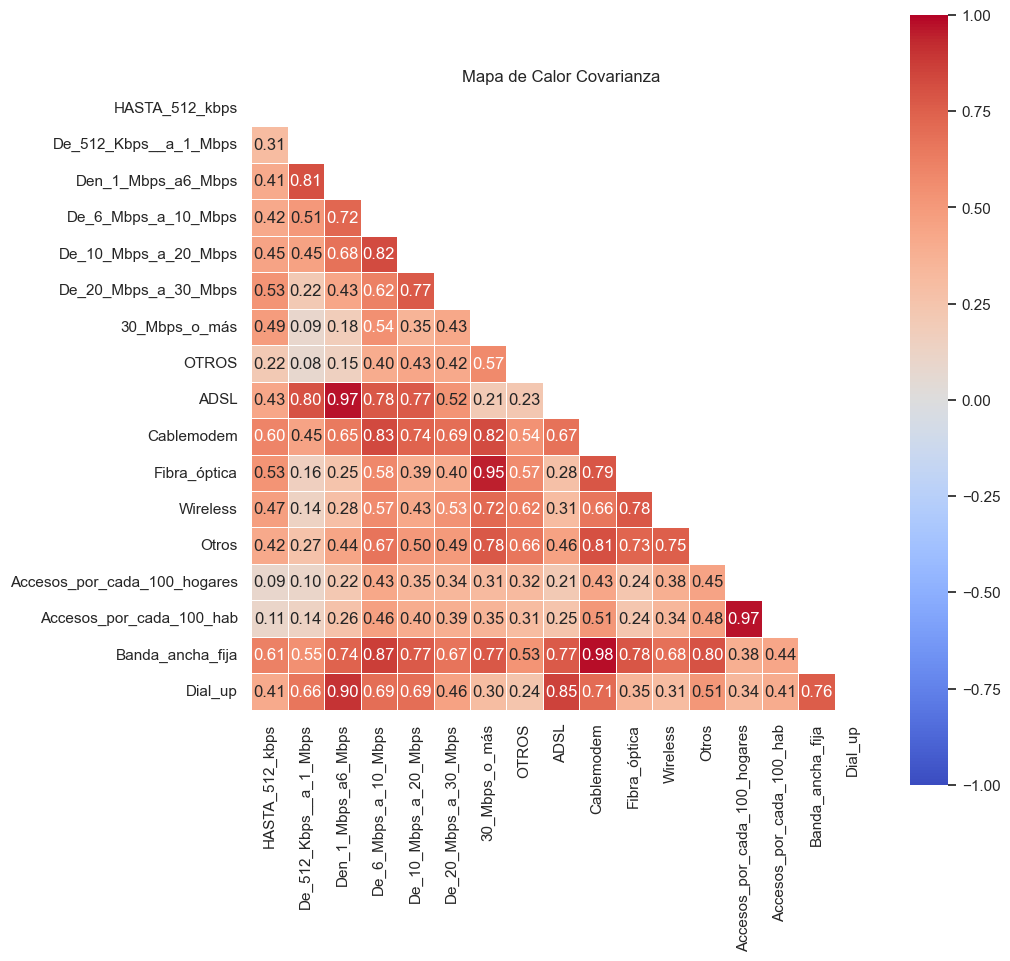

In [49]:
#Creamos un daframe con todos las columnas númericas que se pueden someter a un análisis de covarianza. 

df_cov = df_merged.loc[:,['HASTA_512_kbps','De_512_Kbps__a_1_Mbps','Den_1_Mbps_a6_Mbps',
                    'De_6_Mbps_a_10_Mbps', 'De_10_Mbps_a_20_Mbps','De_20_Mbps_a_30_Mbps', '30_Mbps_o_más', 'OTROS', 'ADSL',
                    'Cablemodem','Fibra_óptica','Wireless', 'Otros', 'Accesos_por_cada_100_hogares', 
                    'Accesos_por_cada_100_hab', 'Banda_ancha_fija','Dial_up']] 

#Primero debemos escalar los datos para que así puedan ser comparables en un análisis de covarianza. 

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_cov)

# Creamos un DataFrame a partir de los datos escalados
scaled_df_cov = pd.DataFrame(scaled_data, columns=df_cov.columns)

cov_matrix = scaled_df_cov.cov()

# Creamos una máscara para la parte superior de la matriz de calor
mask = np.triu(np.ones_like(cov_matrix, dtype=bool))

# Estilo del mapa de calor
sns.set(style='white')

# Creamos y mostramos el mapa de calor con la máscara
plt.figure(figsize=(10, 20))
sns.heatmap(cov_matrix, mask=mask, cmap='coolwarm', vmax=1, vmin=-1, annot=True, fmt=".2f", square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Mapa de Calor Covarianza')
plt.show()

Teniendo en cuenta que podemos decir que existe una correlación fuerte de variables en los rangos [0,7 - 1] o [(-0,7) - (-1)], relizaremos nuestros primeros análisis que 

El gráfico que vamos a desarrollar ahora es un gráfico de barras en el cual el eje x serán los años y el eje y es la cantidad total de personas que poseen internet para cada año; además, cada barra estará dividida por el número de personas que utilizan cierta tecnología de internet. La finalidad de este gráfico es revisar cómo ha evolucionado, en el tiempo, el porcentaje de cada tecnología en el mercado. 

In [50]:
df_tect = df_merged.loc[:,['fecha','Provincia' ,'ADSL','Cablemodem','Fibra_óptica',
                    'Wireless', 'Otros']]

#convertimos fecha en año
df_tect['fecha'] = df_tect['fecha'].dt.year 

#agrupamos y modificamos el dataframe a conveniencia.
df_tect = df_tect.groupby(['fecha', 'Provincia']).mean().reset_index()

df_tect = df_tect.loc[:,['fecha','ADSL','Cablemodem','Fibra_óptica',
                    'Wireless', 'Otros']]

df_tect = df_tect.groupby('fecha').sum().reset_index()

In [51]:
# 'Derretimos' el dataframe para poder preparar la información para graficar ya que hay ciertas operaciones de análisis 
# y visualización que funcionan mejor con datos en formato largo.
df_melted = df_tect.melt(id_vars='fecha', value_vars=['ADSL', 'Cablemodem', 'Fibra_óptica',
                                 'Wireless','Otros'],
                    var_name='Tecnología', value_name='Población')

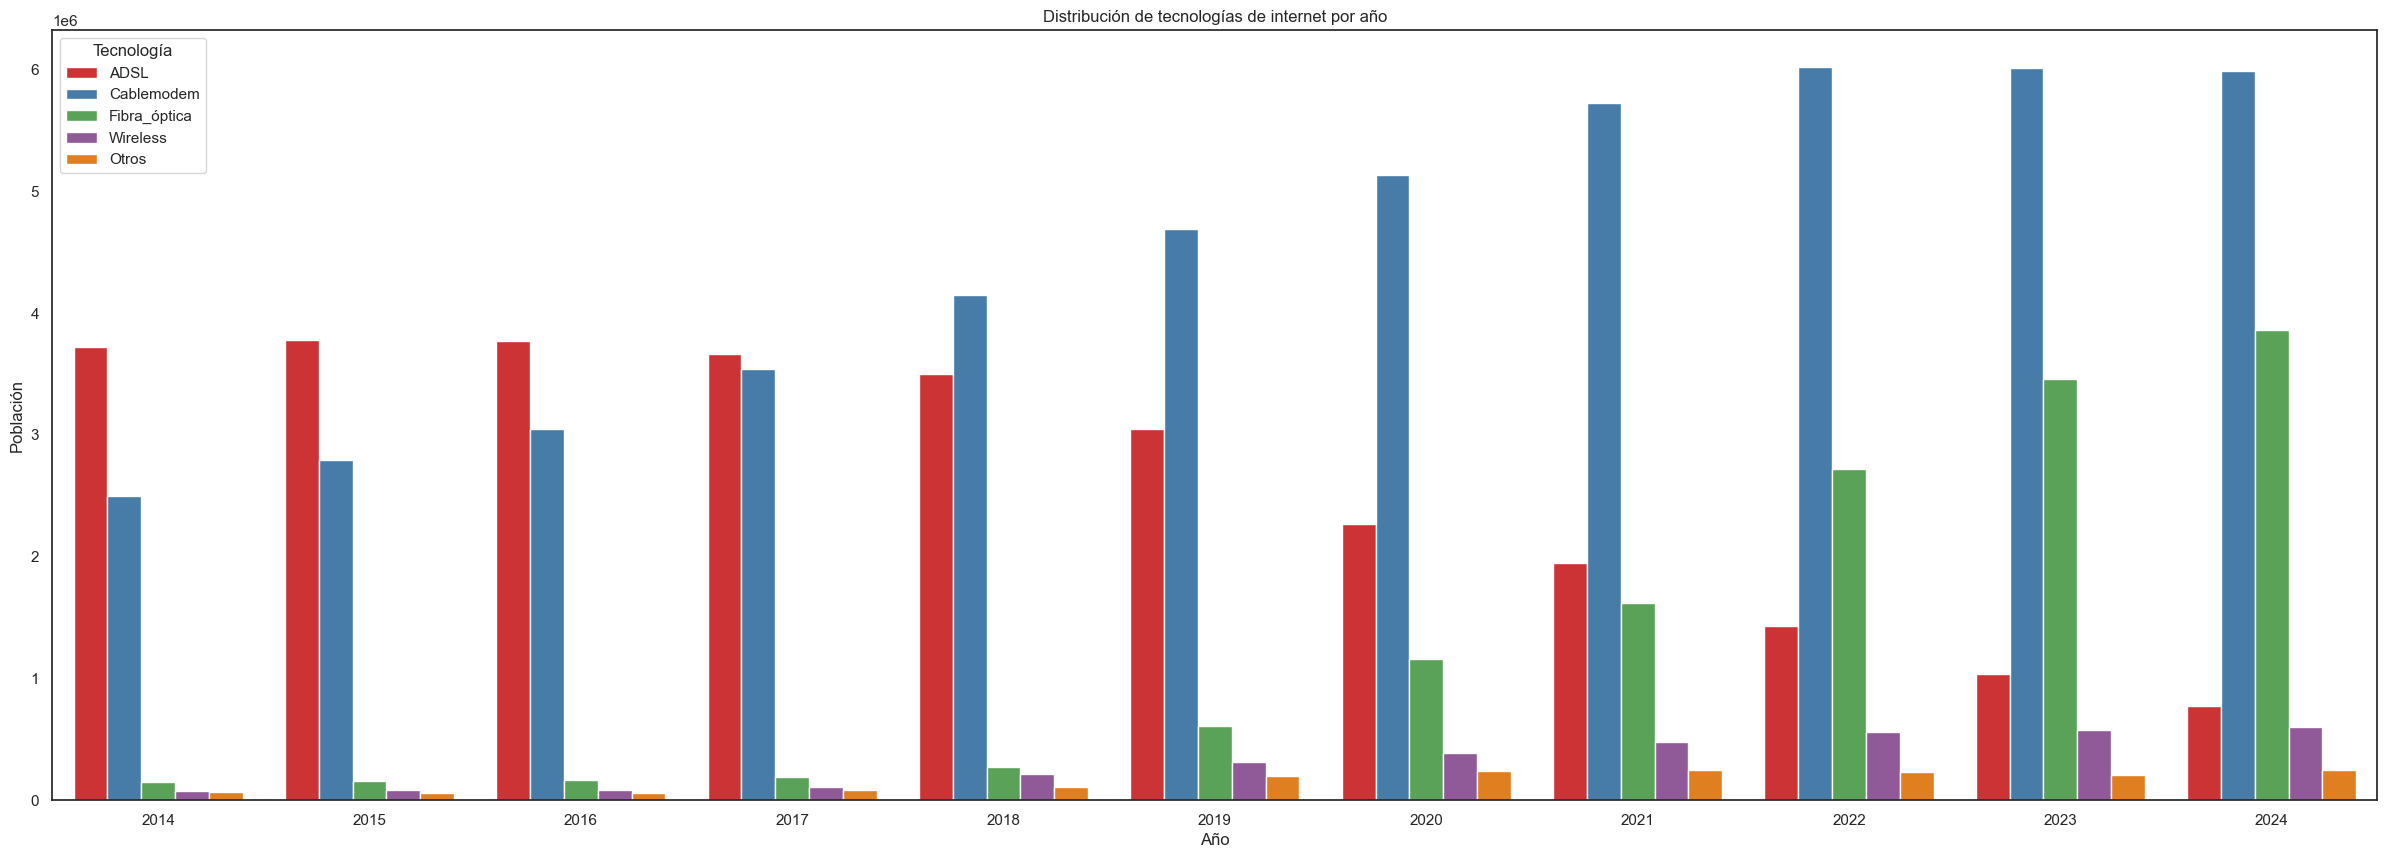

In [52]:
#graficamos

plt.figure(figsize=(30, 10))
sns.barplot(x='fecha', y='Población', hue='Tecnología', data=df_melted, palette='Set1')

plt.title('Distribución de tecnologías de internet por año')
plt.xlabel('Año')
plt.ylabel('Población')
plt.legend(title='Tecnología')
plt.show()

Lo primero que podemos notar en este gráfico es como han aumentado las personas con acceso a internet, a través de diferentes tecnologías, en al menos un 90% en los últimos diez años en la Argentina. Teniendo en cuenta que en estos años el porcentaje de crecimiento poblacional en este país ha sido de alrededor del 1%, podemos concluir que se ha hecho un esfuerzo enorme por aumentar el acceso de la población a internet. 
Al revisar la suma de usuarios para todas las provincias a lo largo de los años, podemos notar que en el 2014 predominaban dos tecnologías por sobre el resto, el ADSL y el cablemódem, siendo el ADSL la tecnología con mayor porcentaje en el 2014; por otro lado, tecnologías como Wireless y Fibra Óptica para ese año tenían un mínimo porcentaje del mercado. Con el paso del tiempo, se puede ver como el cablemódem empieza a ganarle territorio al ADSL, hasta tal punto que pareciera que todos los usuarios que abandonaban la tecnología ADSL se empezaban a pasar al cablemódem, logrando este, alrededor del 2019, superar a la tecnología ADSL en termino de usuarios. Para entender esto debemos entrar un poco en la historia del internet. 
La primera infraestructura que se utilizó para transmitir datos fueron las líneas telefónicas, y allí por los años 80, el Dial-Up nos permitía andar, a duras a penas, a 56 kbps mientras no utilizáramos el teléfono. El teléfono, inventado en 1876 por Alexander Graham Bell, utilizaba las líneas telefónicas para transmitir la voz -una onda sonora que se propaga de manera continua en el tiempo- utilizando señales analógicas -señales electromagnéticos con amplitud y fase variables-. No fue hasta el año 1950 con la creación la modulación, una tecnología que permitía convertir señales digitales (1 y 0) provenientes de una computadora en señales analógicas, que se logró la conexión de dos computadores a distancia a través de las líneas telefónicas. El primer reto que trajo esto fue que la frecuencia utilizada para transmitir voz (300 Hz a 3400 Hz) era la misma para hacer la trasmisión de datos, de ahí que no se pudiera utilizar el internet y la línea telefónica al mismo tiempo. Con la evolución de las telecomunicaciones, se descubrió que se podían utilizar frecuencias más altas, la banda ancha, para la transmisión de datos y las más bajas para las de voz, surgiendo de esta manera la tecnología ASDL. Al utilizarse rangos de frecuencia más amplios, la velocidad aumento de una velocidad simétrica de 56 kps a una velocidad asimétrica de descarga entre 256 kbps y 24 Mbps y de subida entre 64 kbps y 1.4 Mbps. Un cambio radicalmente grande el generado por la modulación, cambio que no fue únicamente aprovechado por las empresas de telefonía ya que las empresas de televisión por cable se dieron cuenta que su red de cables coaxiales, especiales para la transmisión de señales de televisión (señales de alta frecuencia) podían ser una excelente opción para ofrecer transmisión de datos porque, al estar diseñada para altas frecuencias, permiten una mayor banda ancha y, por ende, logran un aumento en las velocidades entre 10 Mbps hasta 1 Gbps para descarga y 1 Mbps a 20 Mbps para subida. Principalmente es esta diferencia de velocidad la que atrajo muchas personas a realizar el cambio de tecnología ASDL a cablemódem. En Argentina las dos tecnologías fueron introducidas en el año 2000, y la tecnología ASDL empieza con una ventaja ya que la infraestructura para su funcionamiento ya existía, mientras que la evolución del cablemódem se fue dando a medida que la cobertura de la televisión por cable aumentaba en el territorio. 
Otro hito importante que podemos ver en el gráfico es la evolución de la fibra óptica. Antes del 2018, la participación de esta tecnología en el mercado, al igual que la Wireless, era bastante pequeña; sin embargo, de ahí en adelante esta empieza a ganar terreno de manera importante, tanto así que para el 2020 pareciera que el crecimiento del cablemódem se hubiera estancado y que ahora todos los nuevos usuarios, más los que siguieron dejando el ASDL, se pasaron a la fibra óptica. La evolución de esta tecnología se debe principalmente a que, a diferencia del ADSL y el cablemódem, esta tecnología no utilizaba infraestructura existente, por lo que, inicialmente, la inversión era más alta debido a la necesidad de desplegar nuevos cables de fibra y equipos; sin embargo, a medida que se ha aumentado la cobertura, el servicio se ha vuelto más asequible. A pesar de que, en cuanto a términos de velocidad, el cablemódem y la fibra óptica son similares; la fibra óptica, al utilizar pulsos de luz para transmitir los datos, es menos susceptible a interferencias electromagnéticas lo que produce menores deterioro en los cables y menores costos de mantenimiento y reparación, haciendo que esta tecnología se siga abriendo paso en el mercado.


Construiremos un gráfico en el cual vamos a revisar el gradiente de variación de los clientes por cada tecnología; además, incluiremos el gradiente de los ingresos y los accesos por cada 100 habitantes.

In [53]:
#Incluimos la informción de ingresos. Realizamos algunas transformaciones. 

#leemos
df_in = pd.read_sql(""" SELECT * FROM Ingresos""", con=connection)

df_in = df_in.drop("Periodo", axis=1, errors='ignore')

#convertimos fecha a datetime y a año.
df_in['fecha'] = pd.to_datetime(df_in['fecha'])
df_in['fecha'] = df_in['fecha'].dt.year

#agrupamos por fecha a través de la suma
df_in = df_in.groupby(['fecha']).sum().reset_index()

#df_in

In [54]:
#tomamos las columnas de interés
df_pen = df_merged.loc[:,['fecha','Provincia' ,'ADSL','Cablemodem','Fibra_óptica',
                    'Wireless', 'Otros','Accesos_por_cada_100_hab']]

#convertimos fecha en año
df_pen['fecha'] = df_pen['fecha'].dt.year 

#Agrupamos por fecha y por provincia por la media.
df_pen = df_pen.groupby(['fecha', 'Provincia']).mean().reset_index()

df_pen = df_pen.sort_values(by=['Provincia', 'fecha'], ascending=[True, True])

#tomamos las columnas de interés
df_pen = df_pen.loc[:,['fecha','ADSL','Cablemodem','Fibra_óptica',
                    'Wireless', 'Otros', 'Accesos_por_cada_100_hab']]

#grupamos por la fecha de nuevo, esta vez sumando para que represente todas las provincias a expceción de 
# Accesos_por_cada_100_hab que se agrupa por el promedio.
df_pen = df_pen.groupby(['fecha']).agg({
    'Accesos_por_cada_100_hab': 'mean',
    'ADSL': 'sum',    
    'Cablemodem': 'sum', 
    'Fibra_óptica': 'sum', 
    'Wireless': 'sum', 
    'Otros': 'sum'}).reset_index()

#combinamos con ingresos
df_pen= pd.merge(df_pen, df_in, on='fecha', how='inner')

#gradiente para tecnologías 

df_penT = df_pen[['fecha', 'ADSL', 'Cablemodem', 'Fibra_óptica', 'Wireless']]
df_penT.set_index('fecha', inplace=True)

#Transponemos para poder calcular mejor los gradientes.
df_Trans = df_penT.T

#calculamos los gradientes para las diferentes tecnologías

df_gradT = pd.DataFrame()
for i in range(df_Trans.shape[1] - 1):
    name = str(df_Trans.columns[i+1]) + '/' + str(df_Trans.columns[i])
    df_gradT[name] = ((df_Trans.iloc[:,i+1] - (df_Trans.iloc[:,i]))/((df_Trans.iloc[:,i+1] - df_Trans.iloc[:,i]).sum()))*100

df_gradT = df_gradT[['2015/2014', '2016/2015', '2017/2016', '2018/2017', '2019/2018', '2020/2019',
                     '2021/2020', '2022/2021', '2023/2022']]

df_gradT = df_gradT.T

#gradiente para tecnologías Accesos_por_cada_100_hab e ingresos

df_penAI = df_pen[['fecha','Accesos_por_cada_100_hab', 'Ingresos_miles_de_pesos']]
df_penAI.set_index('fecha', inplace=True)

#Transponemos para poder calcular mejor los gradientes.
df_TransAI = df_penAI.T

#calculamos los gradientes par ingresos y Accesos_por_cada_100_hab
df_gradAI = pd.DataFrame()
for i in range(df_TransAI .shape[1] - 1):
    name = str(df_TransAI .columns[i+1]) + '/' + str(df_TransAI .columns[i])
    df_gradAI[name] = (df_TransAI .iloc[:,i+1] - (df_TransAI .iloc[:,i]))*100/(df_TransAI .iloc[:,i])

df_gradAI = df_gradAI[['2015/2014', '2016/2015', '2017/2016', '2018/2017', '2019/2018', '2020/2019',
                     '2021/2020', '2022/2021', '2023/2022']]

df_gradAI= df_gradAI.T

#Combinamos para tener toda la información de los gradientes en una sola tabla

df_gradT= pd.merge(df_gradT, df_gradAI,left_index=True, right_index=True)

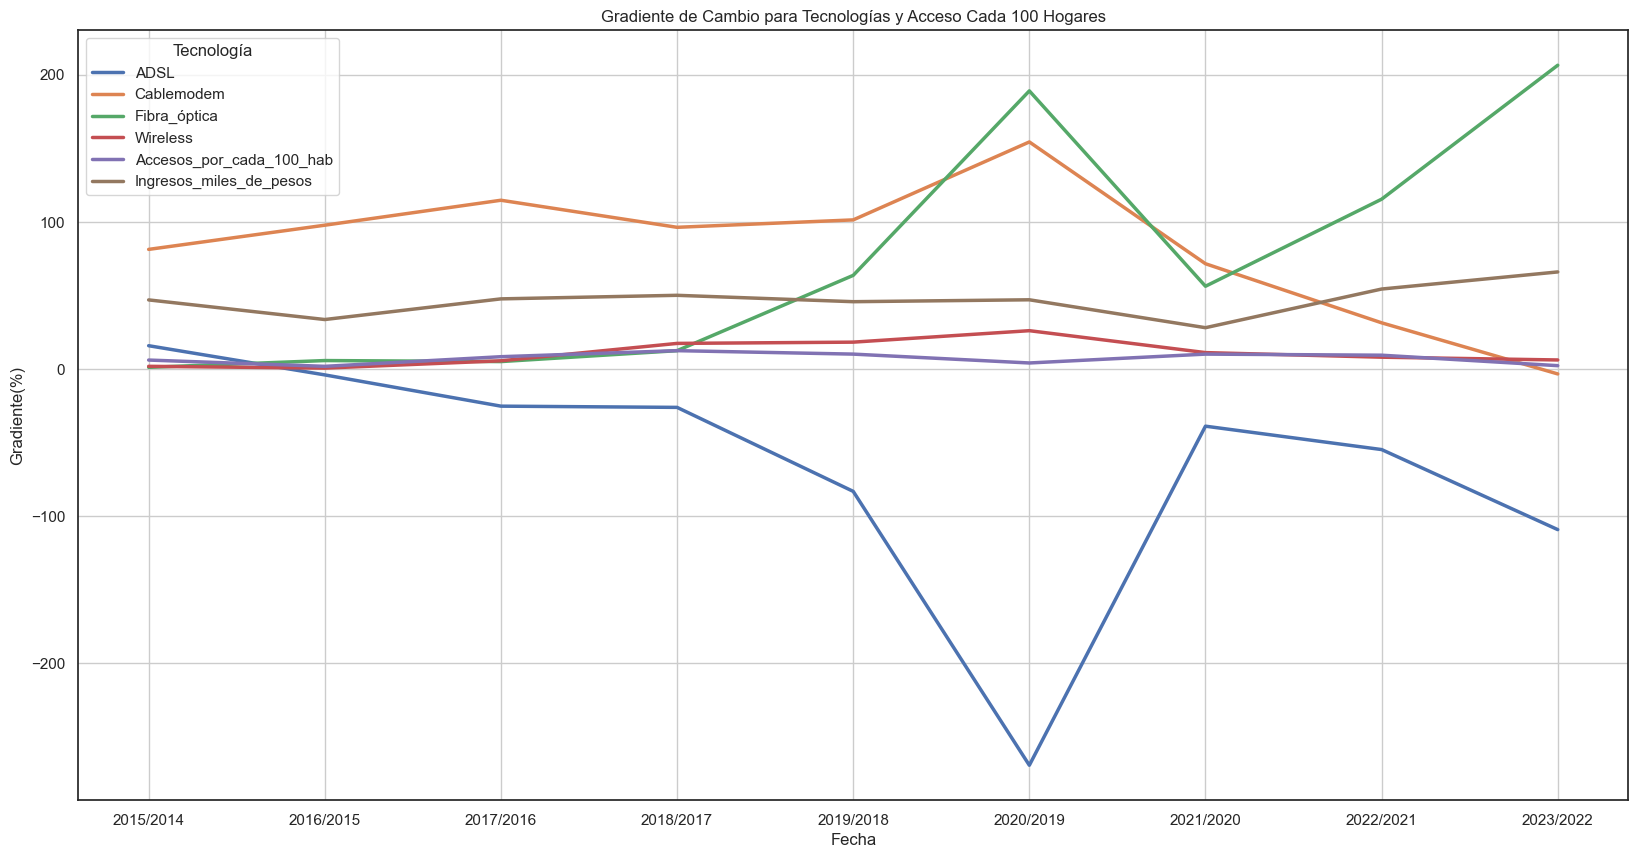

In [55]:
#df_gradT.to_excel('df_gradienteinternet.xlsx', index=True)

#Graficamos
df_gradT_index = df_gradT.index


plt.figure(figsize=(20, 10))
for column in df_gradT.columns:
    plt.plot(df_gradT_index, df_gradT[column], label=column, linewidth= 2.5)

plt.xlabel('Fecha')
plt.ylabel('Gradiente(%)')
plt.title('Gradiente de Cambio para Tecnologías y Acceso Cada 100 Hogares')
plt.legend(title='Tecnología')
plt.grid(True)
plt.show()

Para las tecnologías este gráfico está construido de la siguiente manera:
〖Gradiente tecnología〗_i=(〖usuarios año nuevo〗_i- 〖usuarios año anterior〗_i)/(∑_i^n▒( 〖usuarios año nuevo〗_i- 〖usuarios año anterior〗_i))
Esta medida nos ayuda a dilucidar, cuantitativamente, como ha sido la evolución en el mercado de las diferentes tecnologías. Podemos ver que lo descrito anteriormente es acorde con esta nueva información: desde el 2016, donde la caída del ADSL es de un 4%, es decir, en vez de obtener nuevos usuarios, tuvo perdida de ellos y la perdida de estos, por como está calculado el gradiente, necesariamente es ganancia para otra tecnología, que, para este año, representa, en su mayoría, un aumento para el cablemódem que tiene un porcentaje del 97% de los nuevos usuarios de internet/traslados de otras tecnologías. Otras tecnologías, como Wireless y fibra óptica, abarcan, en este año, alrededor del 6% de los nuevos usuarios. 
Esta tendencia continua hasta el 2018, donde la pérdida de usuarios ADSL sigue en aumento, siendo estas pérdidas, prioritariamente, nuevos usuarios para el cablemódem, aunque se debe hacer una mención especial para la tecnología Wireless, que en el gráfico de barras se veía menos significativa, pero que, sin embargo, su porcentaje, para el 2018, era del 18%. De este año para adelante la tragedia para el ADSL es inminente, con una pérdida de usuarios de un 83% en el 2019 y de un máximo de 270% en el 2020, el año de la pandemia, lo que podría significar que mucha gente decidió buscar mejores velocidades de internet y, por ende, migrar a otras tecnologías debido a la necesidad de trabajar en casa. En esta misma época que empieza el surgimiento de la fibra óptica, donde el 2019 se queda con el 63% de los nuevos usuarios/traslados y con un máximo de 189% en el 2020, superando al cablemódem. Para esto mismos años, el aumento del cablemódem es de 101% y 156%, por lo que, en resumidas cuentas, en estos dos años la pérdida de usuarios del ASDL son traslados al cablemódem o la fibra óptica.
En el 2021, la velocidad de pérdida de usuarios del cablemódem se reduce a un 54%, y podemos seguir viendo un reparto relativamente equitativo entre el cablemódem y la fibra óptica, con porcentajes de 71% y 56% respectivamente, sin embargo, después de este año el porcentaje de nuevos usuarios para el cablemódem cae drásticamente, con un porcentaje del 31% en el 2022 y con una pérdida del 3% para el 2023. Esto significa que, en estos últimos años, la mayoría de pérdida de usuarios del ADLS se trasladaron a la fibra óptica y que, incluso, para el 2023, usuarios de ADLS y Cablemódem se trasladaron a la fibra óptica. Los porcentajes de ganancia de usuarios para la fibra óptica en los últimos años son de 115% y 206%
Ahora que ya hablamos de los nuevos usuarios y traslados entre tecnologías, podemos ver otras dos variables importantes en este gráfico: el gradiente de los accesos por cada 100 habitantes y el de los ingresos. Es interesante notar que la media del aumento en el porcentaje de los accesos por cada 100 habitantes ronda el siete por ciento, mientras que los ingresos tienen una media de aumento del 40%. En un comienzo esto podría parecer contraintuitivo ya que lo lógico sería pensar que los dos deberían aumentar equitativamente. Esta discrepancia se puede entender debido a que el ADSL suele tener planes más baratos debido a que esta tecnología es menos costosa de mantener, además de que los costos de infraestructura ya están amortizados en gran medida. Al haber un traslado masivo de esta tecnología a tecnologías con planes más costosos como el cablemódem y la fibra óptica, esto, claramente, afecta los ingresos percibidos.


El próximo gráfico que vamos a desarrollar es un gráfico de barras en el cual el eje x serán las provincias y el eje y es la cantidad total de personas que poseen internet en cierta provincia; además, cada barra estará dividida por el número de personas que utilizan cierta tecnología de internet. La finalidad de este gráfico es revisar cómo es la distribución de tecnologías por provincia. 

In [56]:
#tomamos las columnas de interés
df_tecp = df_merged.loc[:,['fecha','Provincia' ,'ADSL','Cablemodem','Fibra_óptica',
                    'Wireless', 'Otros']]

#convertimos fecha en año
df_tecp['fecha'] = df_tecp['fecha'].dt.year 

#agrupamos por fecha y provincia a través de la media. 
df_tecp = df_tecp.groupby(['fecha', 'Provincia']).mean().reset_index()

df_tecp = df_tecp.loc[:,['Provincia','ADSL','Cablemodem','Fibra_óptica',
                    'Wireless', 'Otros']] 

#agrupamos por provincia a través de la media. 
df_tecp = df_tecp.groupby(['Provincia']).mean().reset_index()

In [57]:
# 'Derretimos' el dataframe para poder preparar la información para graficar ya que hay ciertas operaciones de análisis 
# y visualización que funcionan mejor con datos en formato largo.
df_melted = df_tecp.melt(id_vars='Provincia', value_vars=['ADSL', 'Cablemodem', 'Fibra_óptica',
                                 'Wireless','Otros'],
                    var_name='Tecnología', value_name='Población')

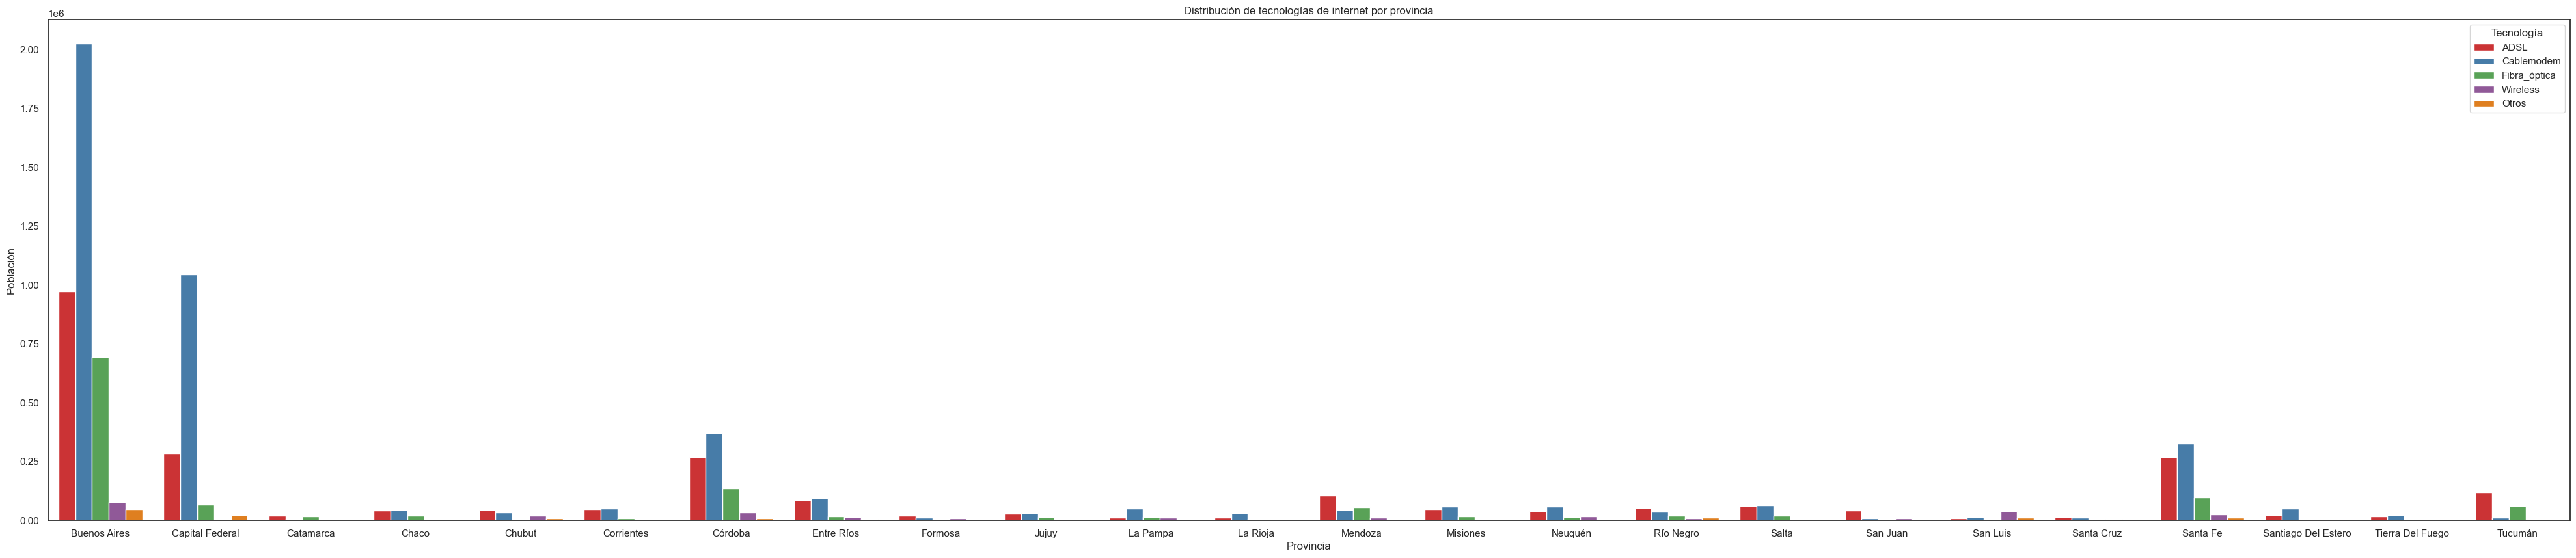

In [58]:
#graficamos

plt.figure(figsize=(50, 10))
sns.barplot(x='Provincia', y='Población', hue='Tecnología', data=df_melted, palette='Set1')

plt.title('Distribución de tecnologías de internet por provincia')
plt.xlabel('Provincia')
plt.ylabel('Población')
plt.legend(title='Tecnología')
plt.show()

En nuestro gráfico de tecnologías, estamos viendo un comportamiento promedio de todas las provincias, pero, teniendo en cuenta que la provincia de Buenos Aires ocupa casi el 50% de la población de Argentina, esta gráfica puede ser una buena aproximación para esa provincia, pero, y el resto ¿sigue este comportamiento? 
Provincias como Chaco, Córdoba, Corrientes, Misiones, Salta, Santiago del Estero, Santa fe, Entre Ríos, La Rioja y Jujuy tienen un comportamiento similar con la provincia de Buenos Aires en cuanto a la evolución de las tecnologías a lo largo del tiempo, con algunas variaciones en los tiempos donde suceden los hitos y la participación de la tecnología Wireless y Otras. 
La Capital federal y Tierra del Fuego tiene una configuración peculiar poque si bien se nota el descenso de del ADSL, en ninguna de los dos existe un surgimiento de la fibra óptica. En el caso de Tierra de Fuego esto puede tener sentido, ya que es la provincia con menos habitantes de Argentina, y puede que los tendidas de líneas de fibra óptica aún no sean una realidad allí, pero en el caso de la capital resulta un poco extraño que no haya pocos servicios de fibra óptica disponible. 
Provincias como Formosa, la Pampa, Rio Negro, Neuquén, San Juan, Chubut y Santa Cruz tienen una particularidad y es que, a pesar de seguir con las tendencias de migración de tecnologías de la provincia de Buenos Aires, en estas provincias existen una fuerte influencia de las tecnologías un poco menos tradicionales, como Wireless y Otras.
Catamarca, Mendoza y Tucumán, tienen una disposición bastante curiosa, ya que más se ve una predominancia del ADSL hasta años después de la media de los anteriores y la primera ola de migración de ADLS a cablemódem está muy por debajo de las otras provincias, pero sí se ve un efecto más acentuado a la migración de la fibra óptica en los últimos años.
El caso de San Luis es el más extraño de todos, con una dominancia casi en una totalidad del Wireless y Otros como las tecnologías para proveer internet; sin embargo, en los últimos años se empieza a notar una pequeña inserción del cablemódem y la fibra óptica. Esto se debe a que, debido a la configuración de su territorio con montañas y zonas rurales extensas, representa un desafío para el tendido de los cables, por lo que el Wireless representa la mejor opción para el acceso a internet en esta provincia. 


Construimos un gráfico de barras en el cual el eje x serán los años y el eje y es la cantidad total de personas que poseen internet para cada año; además, cada barra estará dividido por el número de personas que poseen cierto rango de velocidad de internet. La finalidad de este gráfico es revisar cómo ha evolucionado, en el tiempo, los rangos de velocidad de internet. 

In [59]:
#tomamos columnas de interés
df_vel = df_merged.loc[:,['fecha','Provincia' ,'HASTA_512_kbps','De_512_Kbps__a_1_Mbps','Den_1_Mbps_a6_Mbps',
                    'De_6_Mbps_a_10_Mbps', 'De_10_Mbps_a_20_Mbps','De_20_Mbps_a_30_Mbps', '30_Mbps_o_más','OTROS','Total']]

#convertimos fecha en año
df_vel['fecha'] = df_vel['fecha'].dt.year 

#agrupamos por fecha y provincia a través de la media. 
df_vel = df_vel.groupby(['fecha', 'Provincia']).mean().reset_index()

df_vel = df_vel.loc[:,['fecha','HASTA_512_kbps','De_512_Kbps__a_1_Mbps','Den_1_Mbps_a6_Mbps',
                    'De_6_Mbps_a_10_Mbps', 'De_10_Mbps_a_20_Mbps','De_20_Mbps_a_30_Mbps', '30_Mbps_o_más','OTROS','Total']]

#agrupamos por fecha a través de la suma. 
df_vel = df_vel.groupby('fecha').sum().reset_index()

In [60]:
# 'Derretimos' el dataframe para poder preparar la información para graficar ya que hay ciertas operaciones de análisis 
# y visualización que funcionan mejor con datos en formato largo.
df_melted = df_vel.melt(id_vars='fecha', value_vars=['HASTA_512_kbps', 'De_512_Kbps__a_1_Mbps', 'Den_1_Mbps_a6_Mbps',
                                 'De_10_Mbps_a_20_Mbps','De_20_Mbps_a_30_Mbps','30_Mbps_o_más','OTROS'],
                    var_name='Velocidad', value_name='Población')

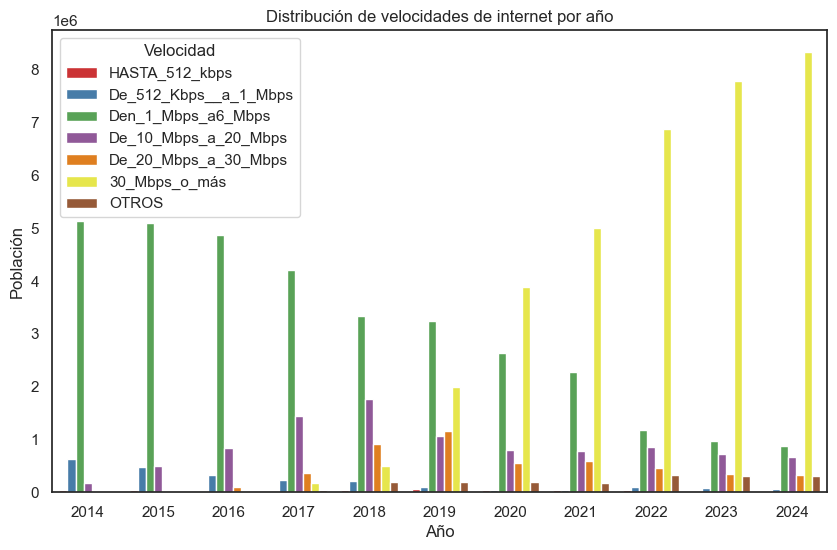

In [61]:
#graficamos

plt.figure(figsize=(10, 6))
sns.barplot(x='fecha', y='Población', hue='Velocidad', data=df_melted, palette='Set1')

plt.title('Distribución de velocidades de internet por año')
plt.xlabel('Año')
plt.ylabel('Población')
plt.legend(title='Velocidad')
plt.show()

Habiendo hablado de las diferentes tecnologías de internet a lo largo de los últimos años en Argentina, esto nos da pie para entender cómo han variado las velocidades de internet en este periodo.
En el año 2014, prácticamente todas las velocidades de internet se encontraban entre 1 Mbps - 6 Mbps, velocidades fácilmente alcanzables por las tecnologías de banda ancha disponibles en la época: el cablemódem y ADSL, tecnologías que ocupaban casi la totalidad del mercado para ese año. Con el paso de los años vemos una transición considerable a velocidades entre 6 Mbps a 20 Mbps, principalmente de 6 Mbps a 10 Mbps, posiblemente por actualizaciones que permitían una mejor velocidad en las dos tecnologías y, para el 2018, vemos que el mercado esta dividido en dos por velocidades de 1 Mbps a 6 Mbps y 1 mayores 6 Mbps repartidas por igual; en este último mayor el porcentaje de 6 Mbps a 20 Mbps, aunque con una ligera participación de más de 30 Mbps que se podría atribuir al comienzo de la ascensión de la fibra óptica. Del 2018 en adelante vemos un ingreso bastante considerable de velocidades de 20 Mbps a 30 Mbps y más de 30 Mbps, especialmente de la última, y un considerable bajonazo en las velocidades de 1 Mbps a 6 Mbps. Teniendo en cuenta que es este mismo año donde se empieza a ver una caída abrupta en los usuarios del ADSL, podemos considerar que este cambio se debe principalmente a usuarios dejando esta tecnología para buscar rangos de velocidad mucho más altos con tecnologías como el cablemódem y la fibra óptica. 
Indudablemente, como lo vemos en la gráfica de velocidad media en el territorio, esta ha aumentado un increíble 1300%, lo que muestra una evolución en las tecnologías e infraestructura de estas en el país. Podemos ver que, en general, la velocidad promedio tiene un incremento estable, pero en el 2022 tiene un crecimiento muy grande que justo está ubicado en fechas similares en lo que empieza a hacer el descenso del cablemódem con respecto a la fibra óptica y esto tiene sentido ya que la fibra óptica es superior cuando se trata de proveer altas velocidades de internet. Es más eficiente, tiene una mayor capacidad de transmisión, mantiene mejor la calidad de la señal sobre largas distancias, y es más resistente a las interferencias.  


Ahora construiremos un gráfico de barras en el cual el eje x serán las provincias y el eje y es la cantidad total de personas que poseen internet en cada provincia; además, cada barra estará dividida en la cantidad de personas que poseen cierto rango de velocidad de internet. La finalidad de este gráfico es revisar cómo se distribuyen las velocidades de internet en las diferentes provincias.

In [62]:
#tomamos columnas de interés
df_prov = df_merged.loc[:,['fecha','Provincia' ,'HASTA_512_kbps','De_512_Kbps__a_1_Mbps','Den_1_Mbps_a6_Mbps',
                    'De_6_Mbps_a_10_Mbps', 'De_10_Mbps_a_20_Mbps','De_20_Mbps_a_30_Mbps', '30_Mbps_o_más','OTROS','Total']]

#convertimos fecha en año
df_prov['fecha'] = df_prov['fecha'].dt.year 

#agrupamos por fecha y provincia a través de la media. 
df_prov = df_prov.groupby(['fecha', 'Provincia']).mean().reset_index()

df_prov = df_prov.loc[:,['Provincia','HASTA_512_kbps','De_512_Kbps__a_1_Mbps','Den_1_Mbps_a6_Mbps',
                    'De_6_Mbps_a_10_Mbps', 'De_10_Mbps_a_20_Mbps','De_20_Mbps_a_30_Mbps', '30_Mbps_o_más','OTROS','Total']] 

#agrupamos por provincia a través de la media. 
df_prov = df_prov.groupby(['Provincia']).mean().reset_index()

In [63]:
# 'Derretimos' el dataframe para poder preparar la información para graficar ya que hay ciertas operaciones de análisis 
# y visualización que funcionan mejor con datos en formato largo.
df_melted = df_prov.melt(id_vars='Provincia', value_vars=['HASTA_512_kbps', 'De_512_Kbps__a_1_Mbps', 'Den_1_Mbps_a6_Mbps',
                                 'De_10_Mbps_a_20_Mbps','De_20_Mbps_a_30_Mbps','30_Mbps_o_más','OTROS'],
                    var_name='Velocidad', value_name='Población')

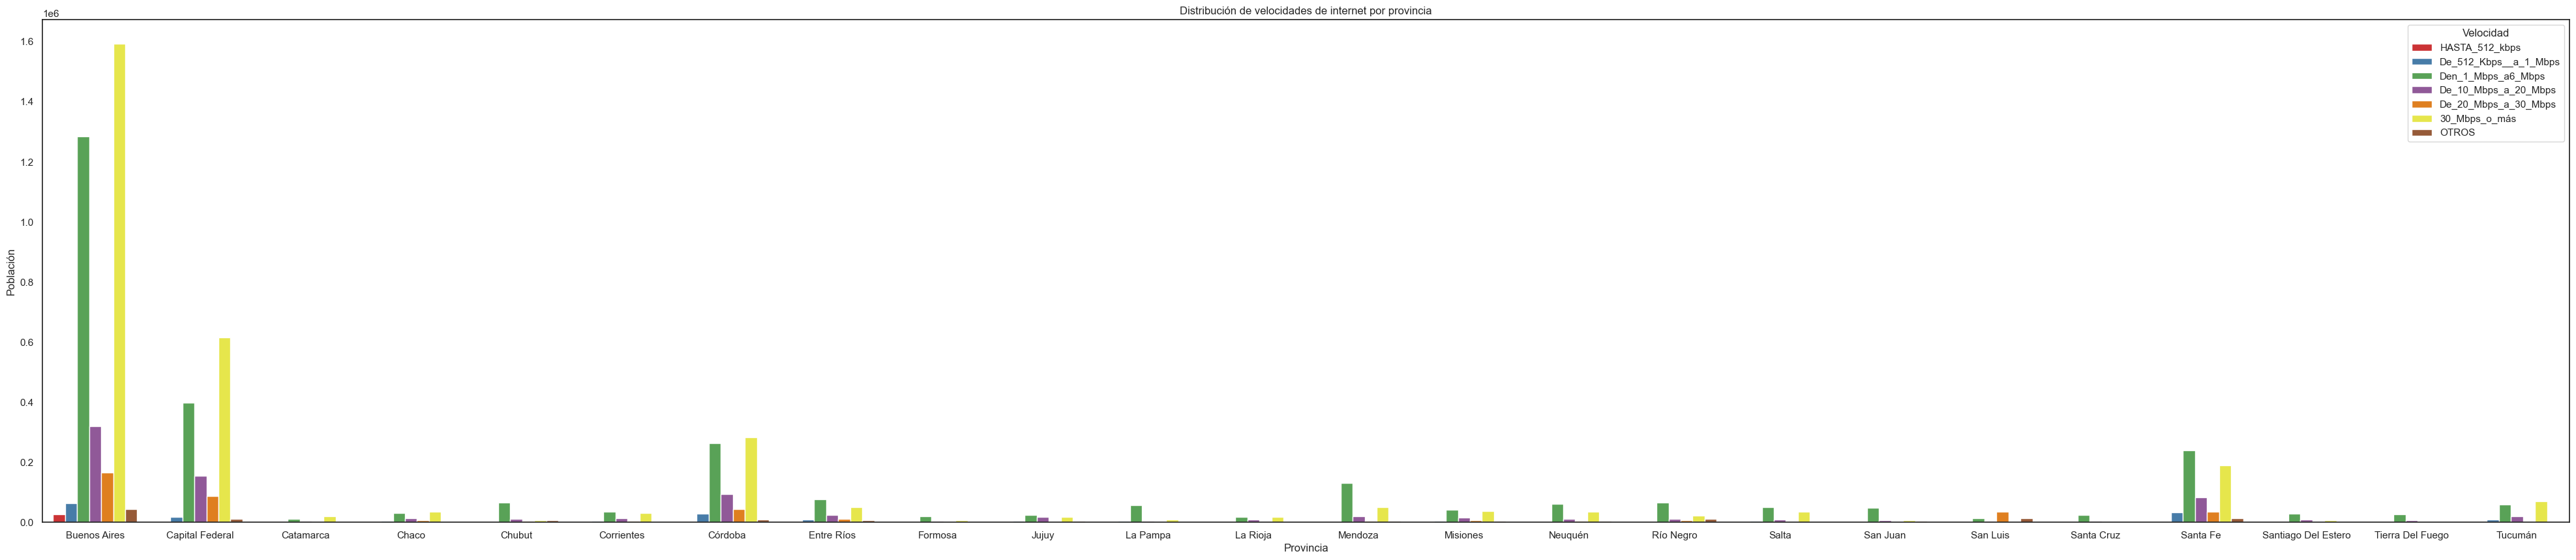

In [64]:
#graficamos

plt.figure(figsize=(50, 10))
sns.barplot(x='Provincia', y='Población', hue='Velocidad', data=df_melted, palette='Set1')

plt.title('Distribución de velocidades de internet por provincia')
plt.xlabel('Provincia')
plt.ylabel('Población')
plt.legend(title='Velocidad')
plt.show()

La distribución de los grupos que vimos en las tecnologías por provincias es similar al que podemos encontrar en las velocidades por provincias. 
A diferencia de nuestro análisis respecto a las tecnologías de las provincias, en cuanto a velocidad podemos formar un grupo más grande y generalizado. Todas las provincias, a excepción de la Capital Federal y San Luis, tienen comportamiento similar con la provincia de Buenos Aires, con variaciones en los tiempos donde suceden los hitos y la participación de las diferentes velocidades. 
La razón de poder unir a la mayoría de las provincias en un sólo grupo es porque es porque, como mencionamos en el análisis de las tecnologías por provincia, había unas que sólo se diferenciaban por un mayor desarrollo de la tecnología Wireless y la fibra óptica. Estas tecnologías tienen velocidades superiores a los 20 Mbps haciendo que, a pesar de ser diferentes tecnologías, la velocidad es similar.
Para las provincias Salta, Entre Ríos, Tierra de Fuego y Santiago de Estero, podemos ver que, en los últimos años, a diferencia de las otras provincias, la participación de velocidades de 20 Mbps a 30 Mbps es una parte considerable del mercado, siendo que, en el caso de Tierra de Fuego y Santiago de Estero, la participación de 30 Mbps o más es bastante pequeña comparada con esta. 
De las provincias La Rioja, Formosa, la Pampa, Río Negro, San Juan, Chubut, Santa Cruz podemos ver que, a pesar de seguir el patrón, el desarrollo de este empieza tardíamente en comparación con las otras provincias de este grupo.
El caso de la Capital Federal es bastante diferente. Para el 2020 la velocidad es, prácticamente 30 Mbps o más. Como vimos en el análisis de tecnología y provincias, desde el 2014 ya la mayoría del servicio era proveído por el cablemódem, lo cual le da sentido que el desarrollo de esta provincia haya sido más rápido que el del resto.
El caso San Luis, en el cual la tecnología Wireless manda la parada, debemos tener en cuenta que la evolución ha sido principalmente de 20 Mbps a 30 Mbps. Teniendo en cuenta que las velocidades del Wireless varían entre 20 Mbps a 50 Mbps, es decir son menores en comparación a tecnologías como el cablemódem y la fibra óptica, este comportamiento tiene sentido.


El siguiente gráfico que vamos a construir es un gráfico de barras en el cual el eje x serán las fechas y el eje y es la cantidad total de personas que poseen internet para cada año; además, cada barra se dividirá en el porcentaje de cómo es la distribución con respecto a dial-up y banda ancha. 

In [65]:
#tomamos columnas de interés
df_baf = df_merged.loc[:,['fecha','Provincia' ,'Banda_ancha_fija','Dial_up']]

#convertimos fecha en año
df_baf['fecha'] = df_baf['fecha'].dt.year 

#agrupamos por fecha y provincia a través de la media. 
df_baf = df_baf.groupby(['fecha', 'Provincia']).mean().reset_index()

df_baf = df_baf.loc[:,['fecha','Banda_ancha_fija','Dial_up']]

#agrupamos por fecha a través de la suma. 
df_baf = df_baf.groupby('fecha').sum().reset_index()

In [66]:
# 'Derretimos' el dataframe para poder preparar la información para graficar ya que hay ciertas operaciones de análisis 
# y visualización que funcionan mejor con datos en formato largo.
df_melted = df_baf.melt(id_vars='fecha', value_vars=['Banda_ancha_fija','Dial_up'],
                    var_name='Baf', value_name='Población')

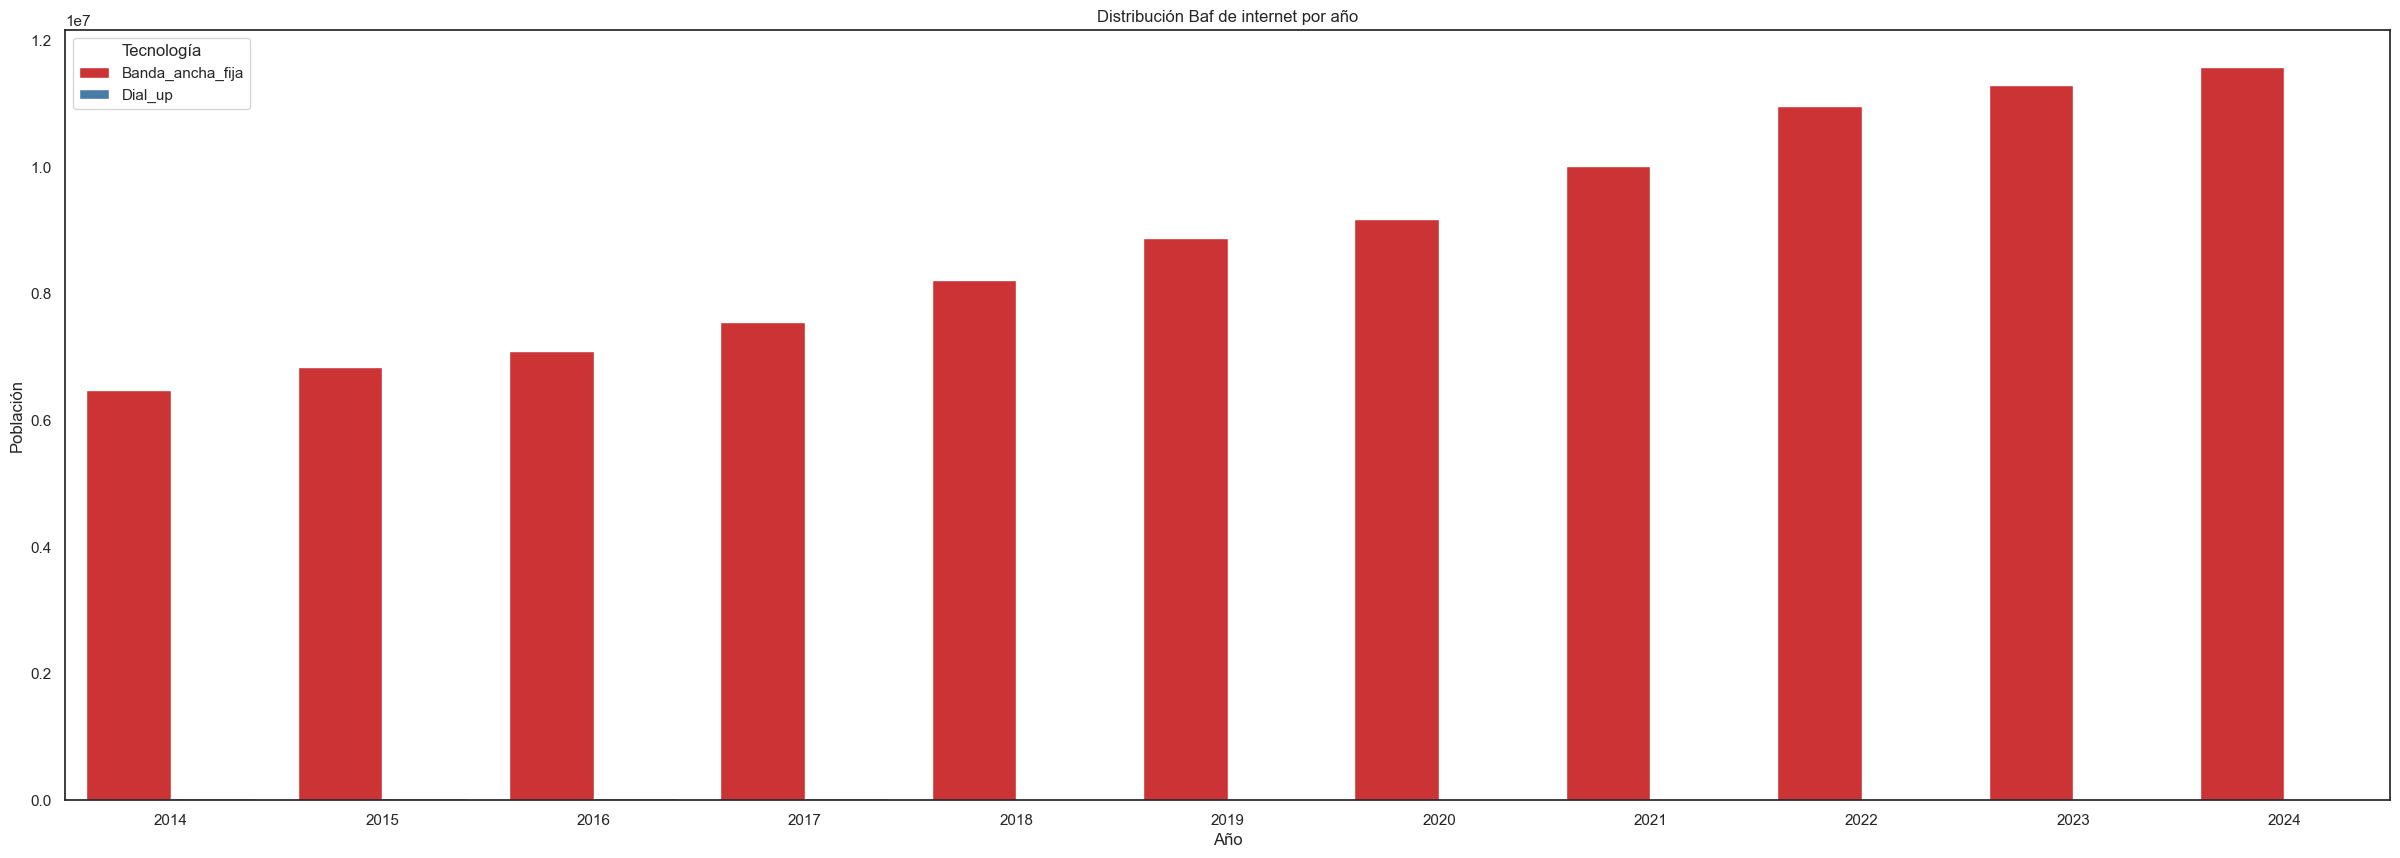

In [67]:
#graficamos

plt.figure(figsize=(30, 10))
sns.barplot(x='fecha', y='Población', hue='Baf', data=df_melted, palette='Set1')

plt.title('Distribución Baf de internet por año')
plt.xlabel('Año')
plt.ylabel('Población')
plt.legend(title='Tecnología')
plt.show()

Como se mencionó anteriormente, las tecnologías ADSL, cablemódem, Wireless y Fibra Óptica son tecnologías de banda ancha, por lo que no sorprende que, básicamente, el 100% del gráfico sea de banda ancha. La tecnología dial-up está relacionada con las velocidades menores a 512 Kbps. 

Con el siguiente gráfico revisaremos si la predominancia de la banda ancha fija es en todo el territorio o si hay algunas provincias donde sea un poco más pareja la situación.

In [68]:
#tomamos columnas de interés

df_bafp = df_merged.loc[:,['fecha','Provincia' ,'Banda_ancha_fija','Dial_up']]

#convertimos fecha en año
df_bafp['fecha'] = df_bafp['fecha'].dt.year 

#agrupamos por fecha y provincia a través de la media. 
df_bafp = df_bafp.groupby(['fecha', 'Provincia']).mean().reset_index()

df_bafp = df_bafp.loc[:,['Provincia','Banda_ancha_fija','Dial_up']] 

#agrupamos por provincia a través de la media. 
df_bafp = df_bafp.groupby(['Provincia']).mean().reset_index()

In [69]:
# 'Derretimos' el dataframe para poder preparar la información para graficar ya que hay ciertas operaciones de análisis 
# y visualización que funcionan mejor con datos en formato largo.
df_melted = df_bafp.melt(id_vars='Provincia', value_vars=['Banda_ancha_fija','Dial_up'],
                    var_name='Baf', value_name='Población')

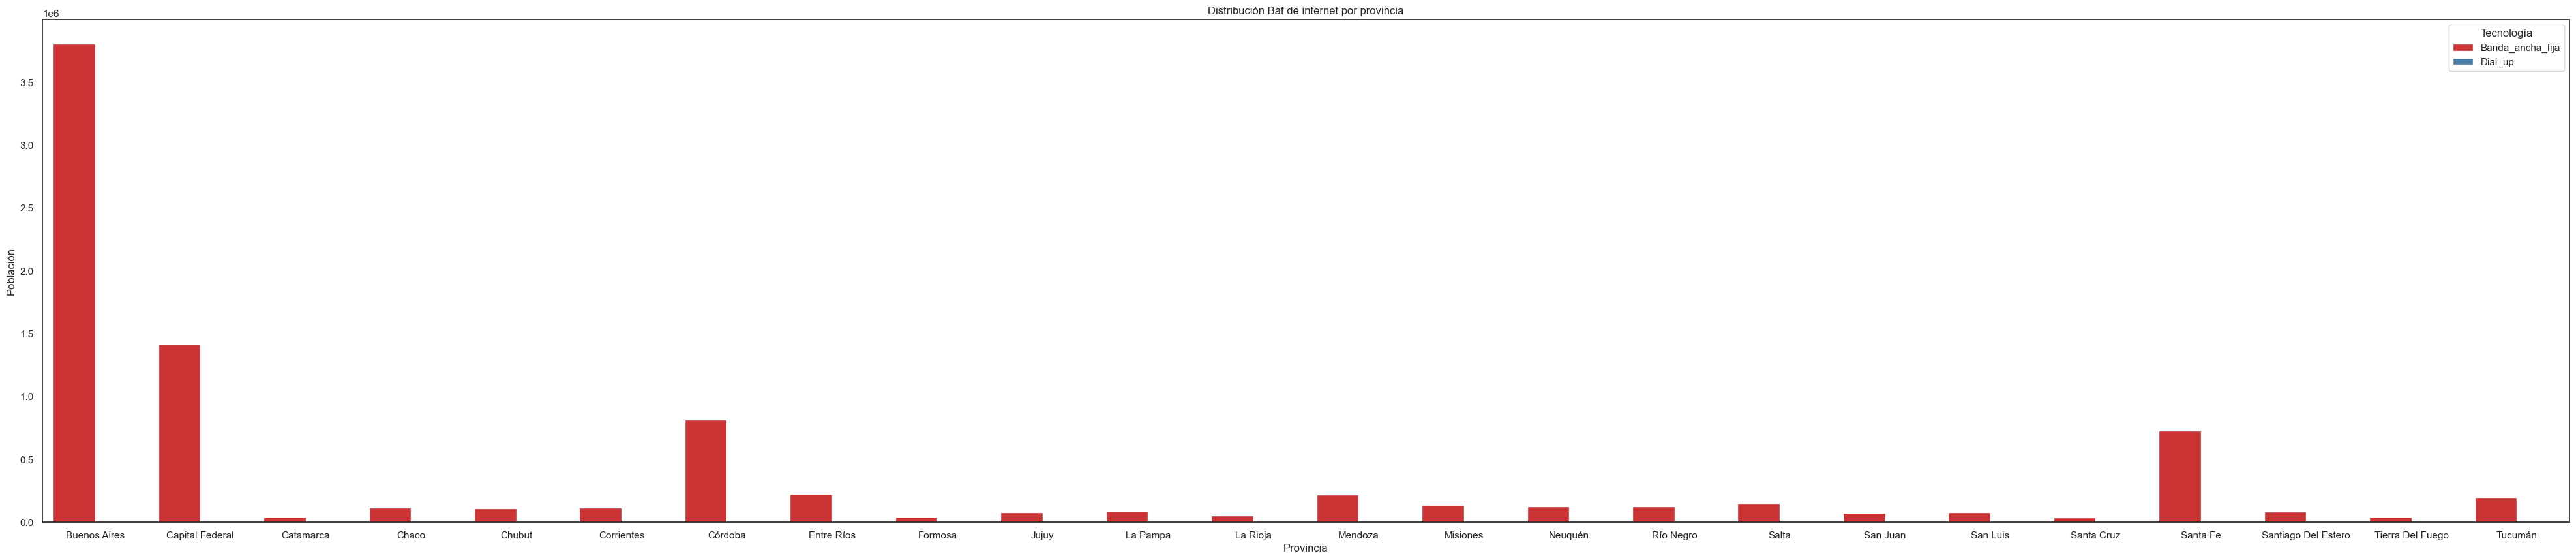

In [70]:
#graficamos

plt.figure(figsize=(50, 10))
sns.barplot(x='Provincia', y='Población', hue='Baf', data=df_melted, palette='Set1')

plt.title('Distribución Baf de internet por provincia')
plt.xlabel('Provincia')
plt.ylabel('Población')
plt.legend(title='Tecnología')
plt.show()

Situación similar con las provincias, al ser las tecnologías ADSL, cablemódem, Wireless y fibra óptica las predominantes desde el periodo 2014, no es extraño que casi el 100% pertenezca a la banda ancha.

Ahora construiremos una tablas con el fin de realizar una comparación de a penetración e ingresos del internet comparado con otras comunicaciones. Empezamos por comparar los accesos por 100 hogares. 

In [71]:
#cargamos telefonía movil y hacemos algunos transformaciones.

df_tel_mov1 = pd.read_excel('C:/Users/LENOVO/Documents/Henry/Segundo_proyecto/datasets/Telefonia_movil.xlsx', sheet_name='Penetracion')
df_tel_mov2 = pd.read_excel('C:/Users/LENOVO/Documents/Henry/Segundo_proyecto/datasets/Telefonia_movil.xlsx', sheet_name='Ingresos')

#hacemos un join para recopilar la información de las dos pestañas
df_tel_mov = pd.merge(df_tel_mov1, df_tel_mov2, on=['Año', 'Trimestre'], how='inner')
df_tel_mov = df_tel_mov.drop(['Periodo_y','Periodo_x'], axis=1, errors='ignore')

#convertimos a fecha el año y periodo 
df_tel_mov['fecha'] = pd.to_datetime(df_tel_mov['Año'].astype(str) + '-' + df_tel_mov['Trimestre'].astype(str))
df_tel_mov = df_tel_mov.drop(['Año','Trimestre'], axis=1, errors='ignore')

#tomamos columnas de interés
df_tel_mov= df_tel_mov[['fecha', 'Accesos por cada 100 hab', 'Ingresos (miles de $)']]

#cambiamos el type de las columnas
df_tel_mov['Accesos por cada 100 hab'] = df_tel_mov['Accesos por cada 100 hab'].astype(float)
df_tel_mov['Ingresos (miles de $)'] = df_tel_mov['Ingresos (miles de $)'].astype(float)

#nos damos cuenta que todos los datos de 'Accesos por cada 100 hab' en telefonia movil son mayores que 100
#lo cual no puede ser cierto porque habría más accesos que población y eso no tiene sentido. Al restarle 100, adquiere
#un poco más de sentido el dato
df_tel_mov['Accesos por cada 100 hab'] = df_tel_mov['Accesos por cada 100 hab'] - 100

#agrupamos por año
df_tel_mov['fecha'] = df_tel_mov['fecha'].dt.year
df_tel_mov = df_tel_mov.groupby(['fecha']).agg({
    'Accesos por cada 100 hab': 'mean',
    'Ingresos (miles de $)': 'sum'})

#renombramos las columnas 
df_tel_mov = df_tel_mov.rename(columns={'Accesos por cada 100 hab': 'Mov_Accesos por cada 100 hab', 
                                'Ingresos (miles de $)': 'Mov_Ingresos (miles de $)'})

#df_tel_mov

In [72]:

#cargamos television y hacemos algunos transformaciones.
df_tel1 = pd.read_excel('C:/Users/LENOVO/Documents/Henry/Segundo_proyecto/datasets/Television.xlsx', sheet_name='Ingresos_TV')
df_tel2 = pd.read_excel('C:/Users/LENOVO/Documents/Henry/Segundo_proyecto/datasets/Television.xlsx', sheet_name='Penetracion_totales_TV')

#hacemos un join para recopilar la información de las dos pestañas
df_tel =  pd.merge(df_tel1, df_tel2, on=['Año', 'Trimestre'], how='inner')

df_tel = df_tel.drop(['Accesos TV por suscripción por cada 100 hogares','Accesos TV satelital por cada 100 hogares'], axis=1, errors='ignore')

#cambiamos el type de las columnas
df_tel['Ingresos TV por suscripción  (miles de $)'] = df_tel['Ingresos TV por suscripción  (miles de $)'].astype(float)
df_tel['Ingresos TV satelital (miles de $)'] = df_tel['Ingresos TV satelital (miles de $)'].astype(float)

#volvemos los ingresos tv totales
df_tel['Ingresos TV(miles de $)'] = df_tel['Ingresos TV por suscripción  (miles de $)'] + df_tel['Ingresos TV satelital (miles de $)']

df_tel = df_tel.drop(['Ingresos TV por suscripción  (miles de $)','Ingresos TV satelital (miles de $)'], axis=1, errors='ignore')

#convertirmos las penetración por 100 hogares al formato correcto
df_tel['Accesos TV satelital por cada 100 hab'] = df_tel['Accesos TV satelital por cada 100 hab'].astype(float)
df_tel['Accesos TV por suscripción por cada 100 hab'] = df_tel['Accesos TV por suscripción por cada 100 hab'].astype(float)

#convertimos a fecha el año y periodo 
df_tel['fecha'] = pd.to_datetime(df_tel['Año'].astype(str) + '-' + df_tel['Trimestre'].astype(str))
df_tel = df_tel.drop(['Año','Trimestre'], axis=1, errors='ignore')

#tomamos columnas de interés
df_tel= df_tel[['fecha', 'Accesos TV por suscripción por cada 100 hab', 'Accesos TV satelital por cada 100 hab', 
                'Ingresos TV(miles de $)']]

#agrupamos por fecha
df_tel['fecha'] = df_tel['fecha'].dt.year
df_tel = df_tel.groupby(['fecha']).agg({
    'Accesos TV por suscripción por cada 100 hab': 'mean',
    'Accesos TV satelital por cada 100 hab': 'mean',
    'Ingresos TV(miles de $)': 'sum'})

df_tel = df_tel.rename(columns={'Accesos TV por suscripción por cada 100 hab': 'Tv_Accesos suscripción cada 100 hab', 
                                'Accesos TV satelital por cada 100 hab': 'Tv_Accesos TV satelital por cada 100 hab',
                                'Ingresos TV(miles de $)': 'Tv_Ingresos (miles de $)'})

#df_tel

In [73]:
#cargamos telefonía fija y hacemos algunos transformaciones.
df_tel_fij1 = pd.read_excel('C:/Users/LENOVO/Documents/Henry/Segundo_proyecto/datasets/telefonia_fija.xlsx', sheet_name='Fija_penetracion_tot')
df_tel_fij2 = pd.read_excel('C:/Users/LENOVO/Documents/Henry/Segundo_proyecto/datasets/telefonia_fija.xlsx', sheet_name='Fija_ingresos')

#hacemos un join para recopilar la información de las dos pestañas
df_tel_fij = pd.merge(df_tel_fij1, df_tel_fij2, on=['Año', 'Trimestre'], how='inner')
df_tel_fij = df_tel_fij.drop('Accesos telefonía fija por cada 100 hogares', axis=1, errors='ignore')

#convertimos a fecha el año y periodo 
df_tel_fij['fecha'] = pd.to_datetime(df_tel_fij['Año'].astype(str) + '-' + df_tel_fij['Trimestre'].astype(str))
df_tel_fij = df_tel_fij.drop(['Año','Trimestre'], axis=1, errors='ignore')

#tomamos las columnas de interés
df_tel_fij= df_tel_fij[['fecha', 'Accesos telefonía fija por cada 100 hab', 'Ingresos (miles de $)']]

#cambiamos las columnas al formato correcto
df_tel_fij['Accesos telefonía fija por cada 100 hab'] = df_tel_fij['Accesos telefonía fija por cada 100 hab'].astype(float)
df_tel_fij['Ingresos (miles de $)'] = df_tel_fij['Ingresos (miles de $)'].astype(float)

#agrupamos por año
df_tel_fij['fecha'] = df_tel_fij['fecha'].dt.year
df_tel_fij = df_tel_fij.groupby(['fecha']).agg({
    'Accesos telefonía fija por cada 100 hab': 'mean',
    'Ingresos (miles de $)': 'sum'})

df_tel_fij = df_tel_fij.rename(columns={'Accesos telefonía fija por cada 100 hab': 'Fij_Accesos por cada 100 hab',                                 
                                'Ingresos (miles de $)': 'Fij_Ingresos (miles de $)'})

#df_tel_fij

In [74]:
#hacemos un join para recopilar la información de las dos pestañas
df_telecomunicaciones= pd.merge(pd.merge(df_tel, df_tel_mov, on='fecha', how='inner'), df_tel_fij, on='fecha', how='inner')

In [75]:
#incluimos la información de ingresos
df_penAI = df_penAI.rename(columns={'Accesos_por_cada_100_hab': 'Inter_Accesos por cada 100 hab',                                 
                                'Ingresos_miles_de_pesos': 'Inter_Ingresos (miles de $)'})

df_telecomunicaciones = pd.merge(df_penAI, df_telecomunicaciones, left_index=True, right_index=True)

#Eliminamos año 2024 ya que par este año sólo tenenmos información de ingresos para el primer trimestre
df_telecomunicaciones = df_telecomunicaciones[~(df_telecomunicaciones.index == 2024)]

#df_telecomunicaciones.to_excel('df_ingresos_accesos_100hab.xlsx', index=True)

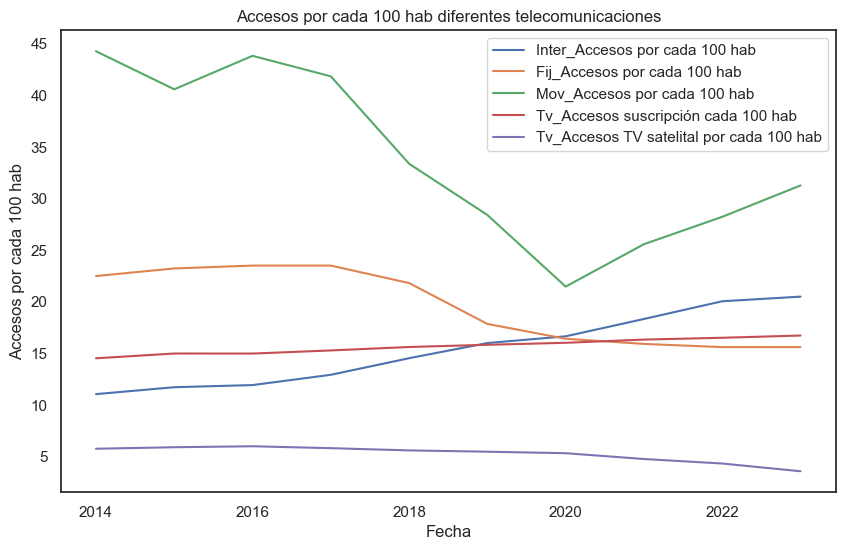

In [76]:
#Graficamos Accesos por cada 100 hab diferentes telecomunicaciones

df_Acc = df_telecomunicaciones[['Inter_Accesos por cada 100 hab', 'Fij_Accesos por cada 100 hab', 
                                'Mov_Accesos por cada 100 hab', 'Tv_Accesos suscripción cada 100 hab', 
                                'Tv_Accesos TV satelital por cada 100 hab' ]]

# Crear un linear plot para cada columna
plt.figure(figsize=(10, 6))

for column in df_Acc.columns:
    sns.lineplot(x=df_Acc.index, y=df_Acc[column], label=column)

plt.xlabel('Fecha')
plt.ylabel('Accesos por cada 100 hab')
plt.title('Accesos por cada 100 hab diferentes telecomunicaciones')
plt.legend()
plt.show()

Lo que podemos ver a primera vista es la abrupta caída del acceso de la telefonía móvil, que cae de un 44% a un 21%, teniendo un mínimo en el 2020 de 16%; la telefonía fija también ha sufrido un descenso del 23% al 16%. Por otra parte, tanto el internet como la TV por subscripción, o cable, han tenido un aumento, de 10% a 20% y de 14% a 17%, respectivamente. En el caso de la TV satelital, ha tenido una caída del 6% al 4%.
Para entender un poco la caída tan abrupta de la telefonía móvil y la caída, menos áspera de la telefonía fija, debemos revisar un poco el contexto económico del país. Desde el 2014, la media de la inflación ha sido del 70%, una situación difícil que afecta significativamente el poder adquisitivo de los ciudadanos. En un entorno marcado por una economía difícil, además teniendo en cuenta que ahora existen aplicaciones VoIP que eliminan las necesidades de llamadas con una línea normal, es muy posible que los usuarios hayan decidido priorizar el internet sobre los servicios de telefonía.
En el caso de la televisión por cable, se considera que su aumento está totalmente ligada a los aumentos de accesos en el internet. Debemos recordar que el cablemódem, una de las tecnologías más importantes para prestar el servicio de internet, utiliza las líneas de la televisión por cable para hacer la transmisión de datos. Debido a que las compañías que proveen televisión por cable vendes paquetes completos, es muy probable que una parte de la población que haya buscado servicio de internet a través de esta tecnología, por defecto, haya también incluido un paquete de televisión por cable.


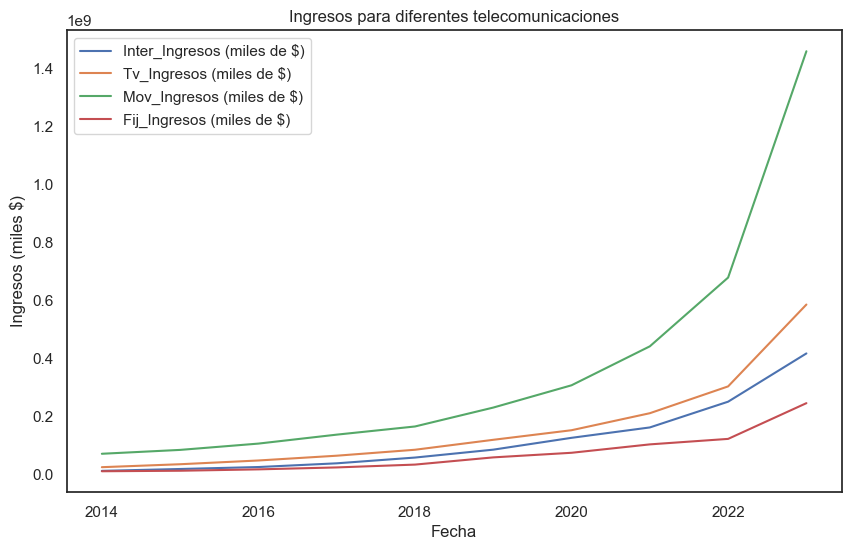

In [77]:
df_ingresostel = df_telecomunicaciones[['Inter_Ingresos (miles de $)', 'Tv_Ingresos (miles de $)', 
                                'Mov_Ingresos (miles de $)', 'Fij_Ingresos (miles de $)']]

# Crear un scatter plot para cada columna
plt.figure(figsize=(10, 6))

for column in df_ingresostel.columns:
    sns.lineplot(x=df_ingresostel.index, y=df_ingresostel[column], label=column)

plt.xlabel('Fecha')
plt.ylabel('Ingresos (miles $)')
plt.title('Ingresos para diferentes telecomunicaciones')
plt.legend()
plt.show()

La tendencia que siguen los ingresos es proporcional a la cantidad de accesos de la tecnología, a excepción de la telefonía móvil; entre más accesos, más ingresos.
Cómo se había mencionado antes, a pesar de ser contraintuitivo que, en el caso de la telefonía móvil, se disminuyan los accesos e igual haya un aumento en los ingresos, esto se puede deber al incremento en el uso de planes de datos para internet, nivelando un poco la pérdida de usuarios. 
En el caso de la telefonía fija, esta al ser la tecnología más económica, es normal que sea la de menores ingresos. A pesar de que esta también sufre de una perdida de clientes a lo largo de los años, su caída no es tan grande como la de la telefonía móvil, por lo que podemos suponer que ajustes en los costos de los planes mantienen los ingresos estables. 
Vemos que tenemos un repunte en los ingresos de todas las tecnologías desde el 2022. Esto se pude deber principalmente a que la inflación paso del 50% al 90% en el 2022; para el 2023 la inflación era del 211%; esto, claramente, afecta el ingreso nominal de las telecomunicaciones sin que se vea afectado realmente el consumo. 


En esta parte vamos a crear el dataframe necesario para realizar el KPI propuesto KPI=((Nuevoacceso−Accesoactual)/Accesoactual)∗100 por provincia y por trimestre. 

KPI_1 y KPI_2.

In [78]:
#filtramos y establecemos fecha como date
df_prop = df_merged [['fecha', 'Provincia', 'Accesos_por_cada_100_hab']]

df_prop['fecha'] = df_prop['fecha'].dt.date

#valores únicos fecha y provincia
Valores_unicos_fecha = df_prop['fecha'].unique()
Valores_unicos_fecha = sorted(Valores_unicos_fecha)

Valores_unicos_provincia = df_prop['Provincia'].unique()

#creamos un data frame con valores únicos fecha, como columnas y provincia, como indices. 
df_kpiprop = pd.DataFrame(columns= Valores_unicos_fecha, index= Valores_unicos_provincia)

#llenamos el dataframe
for i, u in enumerate (df_prop['Accesos_por_cada_100_hab']):

    prov = df_prop['Provincia'][i]
    fecha = df_prop['fecha'][i]

    df_kpiprop.loc[prov, fecha] = u    

#Creamos los gradientes
df_gradkpi = pd.DataFrame()

for i in range(df_kpiprop.shape[1] - 1):
    name = str(df_kpiprop.columns[i])
    df_gradkpi[name] = ((df_kpiprop.iloc[:,i+1]) - (df_kpiprop.iloc[:,i]))*100/(df_kpiprop.iloc[:,i])


df_kpiprop = df_gradkpi.T

#df_kpiprop.to_excel('df_kpi.xlsx', index=True)
#df_gradkpi.to_excel('df_kpi2.xlsx', index=True)

KPI_3

In [79]:
#leemos
df_in2 = pd.read_sql(""" SELECT * FROM Ingresos""", con=connection)

#ajustamos el data frame
df_in2 = df_in2[['fecha', 'Ingresos_miles_de_pesos']]
df_in2.set_index('fecha', inplace=True)
df_in2 = df_in2.sort_index(ascending=True)

#calculamos los gradientes
df_in2=df_in2.T

df_gradkpi2 = pd.DataFrame()

for i in range(df_in2.shape[1] - 1):
    name = str(df_in2.columns[i])
    df_gradkpi2[name] = ((df_in2.iloc[:,i+1]) - (df_in2.iloc[:,i]))*100/(df_in2.iloc[:,i])

df_gradkpi2=df_gradkpi2.T

#df_gradkpi2.to_excel('df_kpi3.xlsx', index=True)